# Machine Translation using Transformer



# Dependencies and Imports

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
!pip install matplotlib
!pip install seaborn
!pip install tensorboard
!pip install spacy
!pip install nltk

In [3]:


import math
import copy
import os
import time
import enum
import argparse

# Visualization related imports
import matplotlib.pyplot as plt
import seaborn

# Deep learning related imports
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.hub import download_url_to_file

# Data manipulation related imports
# Instead of torchtext, we now use Hugging Face's datasets library.
from datasets import load_dataset

import spacy

# BLEU (the metric we'll be using for the machine translation task)
from nltk.translate.bleu_score import corpus_bleu

In [4]:
# Let's create some constants to make the code a bit cleaner

# Architecture related constants taken from the paper
BASELINE_MODEL_NUMBER_OF_LAYERS = 6
BASELINE_MODEL_DIMENSION = 512
BASELINE_MODEL_NUMBER_OF_HEADS = 8
BASELINE_MODEL_DROPOUT_PROB = 0.1
BASELINE_MODEL_LABEL_SMOOTHING_VALUE = 0.1

CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')  # semi-trained models during training will be dumped here
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')          # location where trained models are located
DATA_DIR_PATH = os.path.join(os.getcwd(), 'data')                        # training data will be stored here

os.makedirs(CHECKPOINTS_PATH, exist_ok=True)
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(DATA_DIR_PATH, exist_ok=True)

# Special token symbols used later in the data section
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'
PAD_TOKEN = "<pad>"

# Part 1: Transformer Architecture


In [5]:
class Transformer(nn.Module):

    def __init__(self, model_dimension, src_vocab_size, trg_vocab_size, number_of_heads, number_of_layers, dropout_probability, log_attention_weights=False):
        super().__init__()

        # Embeds source/target token ids into embedding vectors
        self.src_embedding = Embedding(src_vocab_size, model_dimension)
        self.trg_embedding = Embedding(trg_vocab_size, model_dimension)

        # Adds positional information to source/target token's embedding vector
        # (otherwise we'd lose the positional information which is important in human languages)
        self.src_pos_embedding = PositionalEncoding(model_dimension, dropout_probability)
        self.trg_pos_embedding = PositionalEncoding(model_dimension, dropout_probability)

        # All of these will get deep-copied multiple times internally
        mha = MultiHeadedAttention(model_dimension, number_of_heads, dropout_probability, log_attention_weights)
        pwn = PositionwiseFeedForwardNet(model_dimension, dropout_probability)
        encoder_layer = EncoderLayer(model_dimension, dropout_probability, mha, pwn)
        decoder_layer = DecoderLayer(model_dimension, dropout_probability, mha, pwn)

        # Encoder and Decoder stacks
        self.encoder = Encoder(encoder_layer, number_of_layers)
        self.decoder = Decoder(decoder_layer, number_of_layers)

        # Converts final target token representations into log probability vectors of trg_vocab_size dimensionality
        # Why log? -> PyTorch's nn.KLDivLoss expects log probabilities
        self.decoder_generator = DecoderGenerator(model_dimension, trg_vocab_size)

        self.init_params()

    # This part wasn't mentioned in the paper, but it's super important!
    def init_params(self):
        # I tested both PyTorch's default initialization and this, and xavier has tremendous impact! I didn't expect
        # that the model's perf, with normalization layers, is so dependent on the choice of weight initialization.
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src_token_ids_batch, trg_token_ids_batch, src_mask, trg_mask):
        src_representations_batch = self.encode(src_token_ids_batch, src_mask)
        trg_log_probs = self.decode(trg_token_ids_batch, src_representations_batch, trg_mask, src_mask)

        return trg_log_probs

    # Modularize into encode/decode functions for optimizing the decoding/translation process (we'll get to it later)
    def encode(self, src_token_ids_batch, src_mask):
        # Shape = (B, S, D) , where B - batch size, S - longest source token-sequence length and D - model dimension
        # The whole encoder stack perserves this shape
        src_embeddings_batch = self.src_embedding(src_token_ids_batch)  # get embedding vectors for src token ids
        src_embeddings_batch = self.src_pos_embedding(src_embeddings_batch)  # add positional embedding
        src_representations_batch = self.encoder(src_embeddings_batch, src_mask)  # forward pass through the encoder

        return src_representations_batch

    def decode(self, trg_token_ids_batch, src_representations_batch, trg_mask, src_mask):
        trg_embeddings_batch = self.trg_embedding(trg_token_ids_batch)  # get embedding vectors for trg token ids
        trg_embeddings_batch = self.trg_pos_embedding(trg_embeddings_batch)  # add positional embedding

        # Shape (B, T, D), where B - batch size, T - longest target token-sequence length and D - model dimension
        trg_representations_batch = self.decoder(trg_embeddings_batch, src_representations_batch, trg_mask, src_mask)

        # After this line we'll have a shape (B, T, V), where V - target vocab size,
        # decoder generator does a simple linear projection followed by log softmax
        trg_log_probs = self.decoder_generator(trg_representations_batch)

        # Reshape into (B*T, V) as that's a suitable format for passing it into KL div loss
        trg_log_probs = trg_log_probs.reshape(-1, trg_log_probs.shape[-1])

        return trg_log_probs  # the reason I use log here is that PyTorch's nn.KLDivLoss expects log probabilities

# Encoder and Decoder Architecture


High level overview of the functionality:

1. The encoder takes as the input a batch of source sequences whose tokens have already been embedded.
2. It then does 6 iterations (6 layers for the base transformer) of mixing those via attention.
3. The final output will later get consumed by the decoder. That's it.

In [6]:
class Encoder(nn.Module):

    def __init__(self, encoder_layer, number_of_layers):
        super().__init__()
        assert isinstance(encoder_layer, EncoderLayer), f'Expected EncoderLayer got {type(encoder_layer)}.'

        # Get a list of 'number_of_layers' independent encoder layers
        self.encoder_layers = get_clones(encoder_layer, number_of_layers)
        self.norm = nn.LayerNorm(encoder_layer.model_dimension)

    def forward(self, src_embeddings_batch, src_mask):
        # Just update the naming so as to reflect the semantics of what this var will become (the initial encoder layer
        # has embedding vectors as input but later layers have richer token representations)
        src_representations_batch = src_embeddings_batch

        # Forward pass through the encoder stack
        for encoder_layer in self.encoder_layers:
            # src_mask's role is to mask/ignore padded token representations in the multi-headed self-attention module
            src_representations_batch = encoder_layer(src_representations_batch, src_mask)

        # Not mentioned explicitly in the paper
        # (a consequence of using LayerNorm before instead of after the SublayerLogic module)
        return self.norm(src_representations_batch)


class EncoderLayer(nn.Module):

    def __init__(self, model_dimension, dropout_probability, multi_headed_attention, pointwise_net):
        super().__init__()
        num_of_sublayers_encoder = 2
        self.sublayers = get_clones(SublayerLogic(model_dimension, dropout_probability), num_of_sublayers_encoder)

        self.multi_headed_attention = multi_headed_attention
        self.pointwise_net = pointwise_net

        self.model_dimension = model_dimension

    def forward(self, src_representations_batch, src_mask):
        # Define an anonymous (lambda) function which only takes src_representations_batch (srb) as input,
        # this way we have a uniform interface for the sublayer logic.
        encoder_self_attention = lambda srb: self.multi_headed_attention(query=srb, key=srb, value=srb, mask=src_mask)

        # Self-attention MHA sublayer followed by point-wise feed forward net sublayer
        # SublayerLogic takes as the input the data and the logic it should execute (attention/feedforward)
        src_representations_batch = self.sublayers[0](src_representations_batch, encoder_self_attention)
        src_representations_batch = self.sublayers[1](src_representations_batch, self.pointwise_net)

        return src_representations_batch

The decoder has a similar structure to encoder.

1. It again starts with a batch of target sequences whose tokens have already been embedded.
2. It then does 6 iterations (6 layers for the base transformer) of mixing those via attention (this time also attending to source token representations)
3. The final output i.e. target token representations go into the DecoderGenerator module which will convert them
into log probabilities

A really important difference is that the decoder uses **causal masking** so as to prevent tokens from looking into the future.


What this mask tells is that tokens on the left side of the chart can only attend to tokens (columns) whose values are set to 1.0 (True).

As you can see the token can also attend to itself and to tokens that come before - hence **causal**.

In [7]:
class Decoder(nn.Module):

    def __init__(self, decoder_layer, number_of_layers):
        super().__init__()
        assert isinstance(decoder_layer, DecoderLayer), f'Expected DecoderLayer got {type(decoder_layer)}.'

        self.decoder_layers = get_clones(decoder_layer, number_of_layers)
        self.norm = nn.LayerNorm(decoder_layer.model_dimension)

    def forward(self, trg_embeddings_batch, src_representations_batch, trg_mask, src_mask):
        # Just update the naming so as to reflect the semantics of what this var will become
        trg_representations_batch = trg_embeddings_batch

        # Forward pass through the decoder stack
        for decoder_layer in self.decoder_layers:
            # Target mask masks pad tokens as well as future tokens (current target token can't look forward)
            trg_representations_batch = decoder_layer(trg_representations_batch, src_representations_batch, trg_mask, src_mask)

        # Not mentioned explicitly in the paper
        # (a consequence of using LayerNorm before instead of after the SublayerLogic module)
        return self.norm(trg_representations_batch)


class DecoderLayer(nn.Module):

    def __init__(self, model_dimension, dropout_probability, multi_headed_attention, pointwise_net):
        super().__init__()
        num_of_sublayers_decoder = 3
        self.sublayers = get_clones(SublayerLogic(model_dimension, dropout_probability), num_of_sublayers_decoder)

        self.trg_multi_headed_attention = copy.deepcopy(multi_headed_attention)
        self.src_multi_headed_attention = copy.deepcopy(multi_headed_attention)
        self.pointwise_net = pointwise_net

        self.model_dimension = model_dimension

    def forward(self, trg_representations_batch, src_representations_batch, trg_mask, src_mask):
        # Define an anonymous (lambda) function which only takes trg_representations_batch (trb - funny name I know)
        # as input - this way we have a uniform interface for the sublayer logic.
        # The inputs which are not passed into lambdas (masks/srb) are "cached" here that's why the thing works.
        srb = src_representations_batch  # simple/short alias
        decoder_trg_self_attention = lambda trb: self.trg_multi_headed_attention(query=trb, key=trb, value=trb, mask=trg_mask)
        decoder_src_attention = lambda trb: self.src_multi_headed_attention(query=trb, key=srb, value=srb, mask=src_mask)

        # Self-attention MHA sublayer followed by a source-attending MHA and point-wise feed forward net sublayer
        trg_representations_batch = self.sublayers[0](trg_representations_batch, decoder_trg_self_attention)
        trg_representations_batch = self.sublayers[1](trg_representations_batch, decoder_src_attention)
        trg_representations_batch = self.sublayers[2](trg_representations_batch, self.pointwise_net)

        return trg_representations_batch

And the final **level 1** module is the DecoderGenerator (level 0 was the topmost Transformer class).

This module does 2 things:
1. Projects the final decoder token representations of dimension D into V dimensions (target vocabulary size)
2. Applies a log softmax expects log probabilities again

In [8]:
class DecoderGenerator(nn.Module):
    def __init__(self, model_dimension, vocab_size):
        super().__init__()

        self.linear = nn.Linear(model_dimension, vocab_size)

        # -1 stands for apply the log-softmax along the last dimension i.e. over the vocab dimension as the output from
        # the linear layer has shape (B, T, V), B - batch size, T - max target token-sequence, V - target vocab size

        # again using log softmax as PyTorch's nn.KLDivLoss expects log probabilities (just a technical detail)
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, trg_representations_batch):
        # Project from D (model dimension) into V (target vocab size) and apply the log softmax along V dimension
        return self.log_softmax(self.linear(trg_representations_batch))

In [9]:
class SublayerLogic(nn.Module):
    def __init__(self, model_dimension, dropout_probability):
        super().__init__()
        self.norm = nn.LayerNorm(model_dimension)
        self.dropout = nn.Dropout(p=dropout_probability)

    # Note: the original paper had LayerNorm AFTER the residual connection and addition operation
    # multiple experiments I found showed that it's more effective to do it BEFORE, how did they figure out which one is
    # better? Experiments! There is a similar thing in DCGAN and elsewhere.
    def forward(self, representations_batch, sublayer_module):
        # Residual connection between input and sublayer output, details: Page 7, Chapter 5.4 "Regularization",
        return representations_batch + self.dropout(sublayer_module(self.norm(representations_batch)))


class PositionwiseFeedForwardNet(nn.Module):
    """
        It's position-wise because this feed forward net will be independently applied to every token's representation.

        This net will basically be applied independently to every token's representation (you can think of it as if
        there was a nested for-loop going over the batch size and max token sequence length dimensions
        and applied this network to token representations. PyTorch does this auto-magically behind the scenes.

    """
    def __init__(self, model_dimension, dropout_probability, width_mult=4):
        super().__init__()

        self.linear1 = nn.Linear(model_dimension, width_mult * model_dimension)
        self.linear2 = nn.Linear(width_mult * model_dimension, model_dimension)

        # This dropout layer is not explicitly mentioned in the paper but it's common to use to avoid over-fitting
        self.dropout = nn.Dropout(p=dropout_probability)
        self.relu = nn.ReLU()

    # Representations_batch's shape = (B - batch size, S/T - max token sequence length, D- model dimension).
    def forward(self, representations_batch):
        return self.linear2(self.dropout(self.relu(self.linear1(representations_batch))))


#
# Input modules
#


class Embedding(nn.Module):

    def __init__(self, vocab_size, model_dimension):
        super().__init__()
        self.embeddings_table = nn.Embedding(vocab_size, model_dimension)
        self.model_dimension = model_dimension

    def forward(self, token_ids_batch):
        assert token_ids_batch.ndim == 2, f'Expected: (batch size, max token sequence length), got {token_ids_batch.shape}'

        # token_ids_batch has shape (B, S/T), where B - batch size, S/T max src/trg token-sequence length
        # Final shape will be (B, S/T, D) where D is the model dimension, every token id has associated vector
        embeddings = self.embeddings_table(token_ids_batch)

        # (stated in the paper) multiply the embedding weights by the square root of model dimension
        # Page 5, Chapter 3.4 "Embeddings and Softmax"
        return embeddings * math.sqrt(self.model_dimension)


class PositionalEncoding(nn.Module):

    def __init__(self, model_dimension, dropout_probability, expected_max_sequence_length=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_probability)

        # (stated in the paper) Use sine functions whose frequencies form a geometric progression as position encodings,
        # (learning encodings will also work so feel free to change it!). Page 6, Chapter 3.5 "Positional Encoding"
        position_id = torch.arange(0, expected_max_sequence_length).unsqueeze(1)
        frequencies = torch.pow(10000., -torch.arange(0, model_dimension, 2, dtype=torch.float) / model_dimension)

        # Checkout playground.py for visualization of how these look like (it's super simple don't get scared)
        positional_encodings_table = torch.zeros(expected_max_sequence_length, model_dimension)
        positional_encodings_table[:, 0::2] = torch.sin(position_id * frequencies)  # sine on even positions
        positional_encodings_table[:, 1::2] = torch.cos(position_id * frequencies)  # cosine on odd positions

        # Register buffer because we want to save the positional encodings table inside state_dict even though
        # these are not trainable (not model's parameters) so they otherwise would be excluded from the state_dict
        self.register_buffer('positional_encodings_table', positional_encodings_table)

    def forward(self, embeddings_batch):
        assert embeddings_batch.ndim == 3 and embeddings_batch.shape[-1] == self.positional_encodings_table.shape[1], \
            f'Expected (batch size, max token sequence length, model dimension) got {embeddings_batch.shape}'

        # embedding_batch's shape = (B, S/T, D), where S/T max src/trg token-sequence length, D - model dimension
        # So here we get (S/T, D) shape which will get broad-casted to (B, S/T, D) when we try and add it to embeddings
        positional_encodings = self.positional_encodings_table[:embeddings_batch.shape[1]]

        # (stated in the paper) Applying dropout to the sum of positional encodings and token embeddings
        # Page 7, Chapter 5.4 "Regularization"
        return self.dropout(embeddings_batch + positional_encodings)


#
# Helper model functions
#


def get_clones(module, num_of_deep_copies):
    # Create deep copies so that we can tweak each module's weights independently
    return nn.ModuleList([copy.deepcopy(module) for _ in range(num_of_deep_copies)])

# Defining the Attention module



In [10]:
class MultiHeadedAttention(nn.Module):


    def __init__(self, model_dimension, number_of_heads, dropout_probability, log_attention_weights):
        super().__init__()
        assert model_dimension % number_of_heads == 0, f'Model dimension must be divisible by the number of heads.'

        self.head_dimension = int(model_dimension / number_of_heads)
        self.number_of_heads = number_of_heads

        self.qkv_nets = get_clones(nn.Linear(model_dimension, model_dimension), 3)  # identity activation hence "nets"
        self.out_projection_net = nn.Linear(model_dimension, model_dimension)

        self.attention_dropout = nn.Dropout(p=dropout_probability)  # no pun intended, not explicitly mentioned in paper
        self.softmax = nn.Softmax(dim=-1)  # -1 stands for apply the softmax along the last dimension

        self.log_attention_weights = log_attention_weights  # should we log attention weights
        self.attention_weights = None  # for visualization purposes, I cache the weights here (translation_script.py)

    def attention(self, query, key, value, mask):
        # Step 1: Scaled dot-product attention, Page 4, Chapter 3.2.1 "Scaled Dot-Product Attention"
        # Notation: B - batch size, S/T max src/trg token-sequence length, NH - number of heads, HD - head dimension
        # query/key/value shape = (B, NH, S/T, HD), scores shape = (B, NH, S, S), (B, NH, T, T) or (B, NH, T, S)
        # scores have different shapes as MHA is used in 3 contexts, self attention for src/trg and source attending MHA
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.head_dimension)

        # Step 2: Optionally mask tokens whose representations we want to ignore by setting a big negative number
        # to locations corresponding to those tokens (force softmax to output 0 probability on those locations).
        # mask shape = (B, 1, 1, S) or (B, 1, T, T) will get broad-casted (copied) as needed to match scores shape
        if mask is not None:
            scores.masked_fill_(mask == torch.tensor(False), float("-inf"))

        # Step 3: Calculate the attention weights - how much should we attend to surrounding token representations
        attention_weights = self.softmax(scores)

        # Step 4: Not defined in the original paper apply dropout to attention weights as well
        attention_weights = self.attention_dropout(attention_weights)

        # Step 5: based on attention weights calculate new token representations
        # attention_weights shape = (B, NH, S, S)/(B, NH, T, T) or (B, NH, T, S), value shape = (B, NH, S/T, HD)
        # Final shape (B, NH, S, HD) for source MHAs or (B, NH, T, HD) target MHAs (again MHAs are used in 3 contexts)
        intermediate_token_representations = torch.matmul(attention_weights, value)

        return intermediate_token_representations, attention_weights  # attention weights for visualization purposes

    def forward(self, query, key, value, mask):
        batch_size = query.shape[0]

        # Step 1: Input linear projection
        # Notation: B - batch size, NH - number of heads, S/T - max src/trg token-sequence length, HD - head dimension
        # Shape goes from (B, S/T, NH*HD) over (B, S/T, NH, HD) to (B, NH, S/T, HD) (NH*HD=D where D is model dimension)
        query, key, value = [net(x).view(batch_size, -1, self.number_of_heads, self.head_dimension).transpose(1, 2)
                             for net, x in zip(self.qkv_nets, (query, key, value))]

        # Step 2: Apply attention - compare query with key and use that to combine values (see the function for details)
        intermediate_token_representations, attention_weights = self.attention(query, key, value, mask)

        # Potentially, for visualization purposes, log the attention weights, turn off during training though!
        # I had memory problems when I leave this on by default
        if self.log_attention_weights:
            self.attention_weights = attention_weights

        # Step 3: Reshape from (B, NH, S/T, HD) over (B, S/T, NH, HD) (via transpose) into (B, S/T, NHxHD) which is
        # the same shape as in the beginning of this forward function i.e. input to MHA (multi-head attention) module
        reshaped = intermediate_token_representations.transpose(1, 2).reshape(batch_size, -1, self.number_of_heads * self.head_dimension)

        # Step 4: Output linear projection
        token_representations = self.out_projection_net(reshaped)

        return token_representations



# Part 2: Data Pipeline



In [11]:
import pickle  # For caching

# Define a simple Field class to mimic torchtext's Field behavior
class Field:
    def __init__(self, tokenize, init_token=None, eos_token=None, pad_token="<pad>", batch_first=True):
        self.tokenize = tokenize
        self.init_token = init_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.batch_first = batch_first
        self.vocab = {}

    def build_vocab(self, examples, min_freq=1):
        freq = {}
        for ex in examples:
            for token in ex:
                freq[token] = freq.get(token, 0) + 1
        # Start vocab with special tokens
        self.vocab = {}
        for token in [self.pad_token] + ([self.init_token] if self.init_token else []) + ([self.eos_token] if self.eos_token else []):
            if token not in self.vocab:
                self.vocab[token] = len(self.vocab)
        # Add tokens meeting the frequency threshold
        for token, count in freq.items():
            if count >= min_freq and token not in self.vocab:
                self.vocab[token] = len(self.vocab)

    def numericalize(self, tokens):
        # Unknown tokens default to index 0 (usually the pad token)
        return [self.vocab.get(token, 0) for token in tokens]

    @property
    def stoi(self):
        """String to index mapping."""
        return self.vocab

    @property
    def itos(self):
        """Index to string mapping."""
        return {index: token for token, index in self.vocab.items()}



# Let's define a couple of useful enum classes
class DatasetType(enum.Enum):
    IWSLT = 0,
    WMT14 = 1


class LanguageDirection(enum.Enum):
    E2G = 0,
    G2E = 1


def get_datasets_and_vocabs(dataset_path, language_direction, use_iwslt=True, use_caching_mechanism=True):
    # Determine language direction: if German-to-English, then german_to_english is True.
    german_to_english = language_direction == LanguageDirection.G2E.name
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    src_tokenizer = tokenize_de if german_to_english else tokenize_en
    trg_tokenizer = tokenize_en if german_to_english else tokenize_de

    # Create Field processors for source and target with the same parameters as before
    src_field_processor = Field(tokenize=src_tokenizer, pad_token=PAD_TOKEN, batch_first=True)
    trg_field_processor = Field(tokenize=trg_tokenizer, init_token=BOS_TOKEN, eos_token=EOS_TOKEN, pad_token=PAD_TOKEN, batch_first=True)

    MAX_LEN = 100  # filter out examples that have more than MAX_LEN tokens
    filter_pred = lambda x: len(x["src"]) <= MAX_LEN and len(x["trg"]) <= MAX_LEN

    # Define cache file paths (using pickle instead of CSV)
    prefix = 'de_en' if german_to_english else 'en_de'
    prefix += '_iwslt' if use_iwslt else '_wmt14'
    train_cache_path = os.path.join(dataset_path, f'{prefix}_train_cache.pkl')
    val_cache_path = os.path.join(dataset_path, f'{prefix}_val_cache.pkl')
    test_cache_path = os.path.join(dataset_path, f'{prefix}_test_cache.pkl')

    ts = time.time()
    if not use_caching_mechanism or not (os.path.exists(train_cache_path) and os.path.exists(val_cache_path)):
        # Load raw dataset from Hugging Face
        if use_iwslt:
            # Select builder config based on language_direction.
            builder_config = "iwslt2017-de-en" if german_to_english else "iwslt2017-en-de"
            raw_datasets = load_dataset("iwslt2017", builder_config, cache_dir=dataset_path, trust_remote_code=True)
        else:
            raw_datasets = load_dataset("wmt14", "de-en", cache_dir=dataset_path)

        # Function to preprocess each example from the raw dataset
        def preprocess(example):
            # Raw examples have a "translation" field with keys "de" and "en"
            if german_to_english:
                src_text = example["translation"]["de"]
                trg_text = example["translation"]["en"]
            else:
                src_text = example["translation"]["en"]
                trg_text = example["translation"]["de"]
            src_tokens = src_tokenizer(src_text)
            trg_tokens = trg_tokenizer(trg_text)
            # Add init and eos tokens for the target sentence
            if trg_field_processor.init_token is not None:
                trg_tokens = [trg_field_processor.init_token] + trg_tokens
            if trg_field_processor.eos_token is not None:
                trg_tokens = trg_tokens + [trg_field_processor.eos_token]
            return {"src": src_tokens, "trg": trg_tokens}

        # Process splits (assuming the raw dataset has "train", "validation" and optionally "test")
        train_dataset = raw_datasets["train"].map(preprocess)
        val_dataset = raw_datasets["validation"].map(preprocess) if "validation" in raw_datasets else None
        test_dataset = raw_datasets["test"].map(preprocess) if "test" in raw_datasets else None

        # Filter out examples exceeding MAX_LEN tokens
        train_dataset = train_dataset.filter(lambda x: filter_pred(x))
        if val_dataset is not None:
            val_dataset = val_dataset.filter(lambda x: filter_pred(x))
        if test_dataset is not None:
            test_dataset = test_dataset.filter(lambda x: filter_pred(x))

        # Save the processed datasets to cache
        with open(train_cache_path, 'wb') as f:
            pickle.dump(train_dataset, f)
        if val_dataset is not None:
            with open(val_cache_path, 'wb') as f:
                pickle.dump(val_dataset, f)
        if test_dataset is not None:
            with open(test_cache_path, 'wb') as f:
                pickle.dump(test_dataset, f)
    else:
        with open(train_cache_path, 'rb') as f:
            train_dataset = pickle.load(f)
        with open(val_cache_path, 'rb') as f:
            val_dataset = pickle.load(f)
        if os.path.exists(test_cache_path):
            with open(test_cache_path, 'rb') as f:
                test_dataset = pickle.load(f)
        else:
            test_dataset = None

    print(f'Time it took to prepare the data: {time.time() - ts:.3f} seconds.')

    MIN_FREQ = 2
    # Build the vocabulary based on tokenized training data
    src_field_processor.build_vocab(train_dataset["src"], min_freq=MIN_FREQ)
    trg_field_processor.build_vocab(train_dataset["trg"], min_freq=MIN_FREQ)

    # ---------------
    # NEW: Save the vocab to disk right after building it
    # ---------------
    src_vocab_path = os.path.join(dataset_path, "src_vocab.pkl")
    trg_vocab_path = os.path.join(dataset_path, "trg_vocab.pkl")
    with open(src_vocab_path, "wb") as f:
        pickle.dump(src_field_processor.vocab, f)
    with open(trg_vocab_path, "wb") as f:
        pickle.dump(trg_field_processor.vocab, f)
    print(f"Vocab saved to {src_vocab_path} and {trg_vocab_path}")

    return train_dataset, val_dataset, src_field_processor, trg_field_processor


def get_data_loaders(dataset_path, language_direction, dataset_name, batch_size, device):
    train_dataset, val_dataset, src_field_processor, trg_field_processor = get_datasets_and_vocabs(
        dataset_path, language_direction, use_iwslt=(dataset_name == DatasetType.IWSLT.name)
    )

    # Numericalize tokens: convert tokens to their corresponding indices using the built vocab.
    def numericalize(example):
        example["src"] = src_field_processor.numericalize(example["src"])
        example["trg"] = trg_field_processor.numericalize(example["trg"])
        return example

    train_dataset = train_dataset.map(numericalize)
    if val_dataset is not None:
        val_dataset = val_dataset.map(numericalize)

    # Create a simple PyTorch Dataset from the Hugging Face dataset
    class TranslationDataset(torch.utils.data.Dataset):
        def __init__(self, hf_dataset):
            self.dataset = hf_dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            item = self.dataset[idx]
            return item["src"], item["trg"]

    train_data = TranslationDataset(train_dataset)
    val_data = TranslationDataset(val_dataset) if val_dataset is not None else None

    # Define a collate_fn for DataLoader that pads sequences to the maximum length in the batch.
    def collate_fn(batch):
        # Each element in batch is a tuple (src, trg)
        src_seqs, trg_seqs = zip(*batch)
        src_lengths = [len(seq) for seq in src_seqs]
        trg_lengths = [len(seq) for seq in trg_seqs]
        max_src = max(src_lengths)
        max_trg = max(trg_lengths)
        pad_idx_src = src_field_processor.vocab[src_field_processor.pad_token]
        pad_idx_trg = trg_field_processor.vocab[trg_field_processor.pad_token]
        padded_src = [seq + [pad_idx_src] * (max_src - len(seq)) for seq in src_seqs]
        padded_trg = [seq + [pad_idx_trg] * (max_trg - len(seq)) for seq in trg_seqs]
        return (torch.tensor(padded_src, dtype=torch.long, device=device),
                torch.tensor(padded_trg, dtype=torch.long, device=device))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    if val_data is not None:
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    else:
        val_loader = None

    return train_loader, val_loader, src_field_processor, trg_field_processor


global longest_src_sentence, longest_trg_sentence

def batch_size_fn(new_example, count, sofar):
    """
    If we use this function in the BucketIterator the batch size is defined as the total number of tokens.
    (Note: this function is no longer used since we now rely on PyTorch DataLoader with a custom collate_fn)
    """
    global longest_src_sentence, longest_trg_sentence

    if count == 1:
        longest_src_sentence = 0
        longest_trg_sentence = 0

    longest_src_sentence = max(longest_src_sentence, len(new_example["src"]))
    longest_trg_sentence = max(longest_trg_sentence, len(new_example["trg"]) + 2)

    num_of_tokens_in_src_tensor = count * longest_src_sentence
    num_of_tokens_in_trg_tensor = count * longest_trg_sentence

    return max(num_of_tokens_in_src_tensor, num_of_tokens_in_trg_tensor)


Those were the main functions we need to later feed the data to the transformer inside the training loop!

Now let's just define some functions which will get called in the training loop and will provide us with:
1. correct source/target masks
2. correct batches of token ids

In [12]:
def get_masks_and_count_tokens_src(src_token_ids_batch, pad_token_id):
    batch_size = src_token_ids_batch.shape[0]

    # src_mask shape = (B, 1, 1, S); masks pad tokens so that they are ignored in attention.
    src_mask = (src_token_ids_batch != pad_token_id).view(batch_size, 1, 1, -1)
    num_src_tokens = torch.sum(src_mask.long())

    return src_mask, num_src_tokens


def get_masks_and_count_tokens_trg(trg_token_ids_batch, pad_token_id):
    batch_size = trg_token_ids_batch.shape[0]
    device = trg_token_ids_batch.device

    # Create a padding mask for the target tokens.
    trg_padding_mask = (trg_token_ids_batch != pad_token_id).view(batch_size, 1, 1, -1)

    # Create a no-look-forward mask to prevent target tokens from attending to future tokens.
    sequence_length = trg_token_ids_batch.shape[1]
    trg_no_look_forward_mask = torch.triu(torch.ones((1, 1, sequence_length, sequence_length), device=device) == 1).transpose(2, 3)

    # Both masks are applied: a token is attended to only if it isn't a pad and it's not a future token.
    trg_mask = trg_padding_mask & trg_no_look_forward_mask
    num_trg_tokens = torch.sum(trg_padding_mask.long())

    return trg_mask, num_trg_tokens


def get_masks_and_count_tokens(src_token_ids_batch, trg_token_ids_batch, pad_token_id, device):
    src_mask, num_src_tokens = get_masks_and_count_tokens_src(src_token_ids_batch, pad_token_id)
    trg_mask, num_trg_tokens = get_masks_and_count_tokens_trg(trg_token_ids_batch, pad_token_id)

    return src_mask, trg_mask, num_src_tokens, num_trg_tokens


def get_src_and_trg_batches(token_ids_batch):
    # In our updated DataLoader, token_ids_batch is a tuple (src, trg) rather than an object with attributes.
    src_token_ids_batch, trg_token_ids_batch = token_ids_batch

    # For training, the target input is the target sequence shifted by one.
    trg_token_ids_batch_input = trg_token_ids_batch[:, :-1]

    # The ground truth is the target sequence shifted to the left, reshaped to (B*T, 1) for loss computation.
    trg_token_ids_batch_gt = trg_token_ids_batch[:, 1:].reshape(-1, 1)

    return src_token_ids_batch, trg_token_ids_batch_input, trg_token_ids_batch_gt


## Caching mechanism



In [13]:
# Updated caching mechanism datasets and functions (no torchtext dependency)

# A simple Example class to hold tokenized source and target sentences.
class Example:
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

# A simple implementation of interleave_keys for sorting.
def interleave_keys(a, b):
    # Simple interleaving by scaling a and adding b.
    # (Not as sophisticated as torchtext's version but sufficient for our use case.)
    return a * 10000 + b

# We subclass torch.utils.data.Dataset instead of torchtext's Dataset.
class FastTranslationDataset(torch.utils.data.Dataset):
    """
    Caching mechanism to speed up data loading.
    Reads a cache file where source and target tokenized examples are interleaved:
    even lines are source, odd lines are target.
    """
    @staticmethod
    def sort_key(ex):
        return interleave_keys(len(ex.src), len(ex.trg))

    def __init__(self, cache_path, fields, **kwargs):
        # Read cached data from the cache file.
        with open(cache_path, encoding='utf-8') as f:
            cached_data = [line.strip().split() for line in f]

        # Even lines: source examples; odd lines: target examples.
        cached_data_src = cached_data[0::2]
        cached_data_trg = cached_data[1::2]

        assert len(cached_data_src) == len(cached_data_trg), "Source and target data should be of the same length."

        self.examples = []
        src_dataset_total_number_of_tokens = 0
        trg_dataset_total_number_of_tokens = 0

        for src_tokens, trg_tokens in zip(cached_data_src, cached_data_trg):
            ex = Example(src_tokens, trg_tokens)
            self.examples.append(ex)
            src_dataset_total_number_of_tokens += len(src_tokens)
            trg_dataset_total_number_of_tokens += len(trg_tokens)

        # Parse cache filename to print dataset information.
        filename_parts = os.path.split(cache_path)[1].split('_')
        src_language, trg_language = ('English', 'German') if filename_parts[0] == 'en' else ('German', 'English')
        dataset_name = 'IWSLT' if filename_parts[2] == 'iwslt' else 'WMT-14'
        dataset_type = 'train' if filename_parts[3] == 'train' else 'val'
        print(f'{dataset_type} dataset ({dataset_name}) has {src_dataset_total_number_of_tokens} tokens in the source language ({src_language}) corpus.')
        print(f'{dataset_type} dataset ({dataset_name}) has {trg_dataset_total_number_of_tokens} tokens in the target language ({trg_language}) corpus.')

        self.fields = fields  # Stored for potential later use.
        self.kwargs = kwargs

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        return self.examples[index]


class DatasetWrapper(FastTranslationDataset):
    """
    A simple wrapper for FastTranslationDataset to load both train and validation datasets.
    """
    @classmethod
    def get_train_and_val_datasets(cls, train_cache_path, val_cache_path, fields, **kwargs):
        train_dataset = cls(train_cache_path, fields, **kwargs)
        val_dataset = cls(val_cache_path, fields, **kwargs)
        return train_dataset, val_dataset


def save_cache(cache_path, dataset):
    """
    Saves the tokenized examples from dataset.examples into a cache file.
    Source examples are written on even lines, target examples on odd lines.
    """
    with open(cache_path, 'w', encoding='utf-8') as cache_file:
        for ex in dataset.examples:
            cache_file.write(' '.join(ex.src) + '\n')
            cache_file.write(' '.join(ex.trg) + '\n')




# Part 3: Training loop utilities



In [14]:
class CustomLRAdamOptimizer:
    """
        Linear ramp learning rate for the warm-up number of steps and then start decaying
        according to the inverse square root law of the current training step number.

        Check out playground.py for visualization of the learning rate (visualize_custom_lr_adam).
    """

    def __init__(self, optimizer, model_dimension, num_of_warmup_steps):
        self.optimizer = optimizer
        self.model_size = model_dimension
        self.num_of_warmup_steps = num_of_warmup_steps

        self.current_step_number = 0

    def step(self):
        self.current_step_number += 1
        current_learning_rate = self.get_current_learning_rate()

        for p in self.optimizer.param_groups:
            p['lr'] = current_learning_rate

        self.optimizer.step()  # apply gradients

    # Check out the formula at Page 7, Chapter 5.3 "Optimizer" and playground.py for visualization
    def get_current_learning_rate(self):
        # For readability purpose
        step = self.current_step_number
        warmup = self.num_of_warmup_steps

        return self.model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))

    def zero_grad(self):
        self.optimizer.zero_grad()

In [ ]:
class LabelSmoothingDistribution(nn.Module):
    """
        Instead of one-hot target distribution set the target word's probability to "confidence_value" (usually 0.9)
        and distribute the rest of the "smoothing_value" mass (usually 0.1) over the rest of the vocab.

        Check out playground.py for visualization of how the smooth target distribution looks like compared to one-hot.
    """

    def __init__(self, smoothing_value, pad_token_id, trg_vocab_size, device):
        assert 0.0 <= smoothing_value <= 1.0

        super(LabelSmoothingDistribution, self).__init__()

        self.confidence_value = 1.0 - smoothing_value
        self.smoothing_value = smoothing_value

        self.pad_token_id = pad_token_id
        self.trg_vocab_size = trg_vocab_size
        self.device = device

    def forward(self, trg_token_ids_batch):

        batch_size = trg_token_ids_batch.shape[0]
        smooth_target_distributions = torch.zeros((batch_size, self.trg_vocab_size), device=self.device)

        # -2 because we are not distributing the smoothing mass over the pad token index and over the ground truth index
        # those 2 values will be overwritten by the following 2 lines with confidence_value and 0 (for pad token index)
        smooth_target_distributions.fill_(self.smoothing_value / (self.trg_vocab_size - 2))

        smooth_target_distributions.scatter_(1, trg_token_ids_batch, self.confidence_value)
        smooth_target_distributions[:, self.pad_token_id] = 0.

        # If we had a pad token as a target we set the distribution to all 0s instead of smooth labeled distribution
        smooth_target_distributions.masked_fill_(trg_token_ids_batch == self.pad_token_id, 0.)

        return smooth_target_distributions

In [15]:
# Calculate the BLEU-4 score
def calculate_bleu_score(transformer, token_ids_loader, trg_field_processor):
    with torch.no_grad():
        pad_token_id = trg_field_processor.stoi[PAD_TOKEN]

        gt_sentences_corpus = []
        predicted_sentences_corpus = []

        ts = time.time()
        for batch_idx, token_ids_batch in enumerate(token_ids_loader):
            # Updated: DataLoader now returns a tuple (src, trg)
            src_token_ids_batch, trg_token_ids_batch = token_ids_batch
            if batch_idx % 10 == 0:
                print(f'batch={batch_idx}, time elapsed = {time.time()-ts} seconds.')

            # Compute source token representations only once
            src_mask, _ = get_masks_and_count_tokens_src(src_token_ids_batch, pad_token_id)
            src_representations_batch = transformer.encode(src_token_ids_batch, src_mask)

            predicted_sentences = greedy_decoding(transformer, src_representations_batch, src_mask, trg_field_processor)
            predicted_sentences_corpus.extend(predicted_sentences)  # Add predictions to corpus

            # Convert ground truth token IDs to tokens using the custom Field's reverse mapping
            trg_token_ids_batch = trg_token_ids_batch.cpu().numpy()
            for target_sentence_ids in trg_token_ids_batch:
                target_sentence_tokens = [trg_field_processor.itos[id] for id in target_sentence_ids if id != pad_token_id]
                gt_sentences_corpus.append([target_sentence_tokens])  # Append as a single-element list per sentence

        bleu_score = corpus_bleu(gt_sentences_corpus, predicted_sentences_corpus)
        print(f'BLEU-4 corpus score = {bleu_score}, corpus length = {len(gt_sentences_corpus)}, time elapsed = {time.time()-ts} seconds.')
        return bleu_score


As you can see to calculate the BLEU score we need a decoding function.

The original paper used **beam search** but for now I've only got **greedy** implemented. <br/> It's not crucial to have beam search to understand how transformers work so this is fine.

*Note: The BLEU metric will give us a pessimistic estimate of our model's perf as the beam search usually gives better results.*

In [16]:
def greedy_decoding(baseline_transformer, src_representations_batch, src_mask, trg_field_processor, max_target_tokens=100):
    """
    Supports batch (decode multiple source sentences) greedy decoding.

    Decoding could be further optimized to cache old token activations because they can't look ahead and so
    adding a newly predicted token won't change old token's activations.

    Example: we input <s> and do a forward pass. We get intermediate activations for <s> and at the output at position
    0, after the doing linear layer we get e.g. token <I>. Now we input <s>,<I> but <s>'s activations will remain
    the same. Similarly say we now got <am> at output position 1, in the next step we input <s>,<I>,<am> and so <I>'s
    activations will remain the same as it only looks at/attends to itself and to <s> and so forth.
    """
    device = next(baseline_transformer.parameters()).device
    pad_token_id = trg_field_processor.stoi[PAD_TOKEN]

    # Initial prompt is the beginning/start of the sentence token. Make it compatible shape with source batch => (B,1)
    target_sentences_tokens = [[BOS_TOKEN] for _ in range(src_representations_batch.shape[0])]
    trg_token_ids_batch = torch.tensor([[trg_field_processor.stoi[tokens[0]]] for tokens in target_sentences_tokens], device=device)

    # Set to true for a particular target sentence once it reaches the EOS (end-of-sentence) token
    is_decoded = [False] * src_representations_batch.shape[0]

    while True:
        trg_mask, _ = get_masks_and_count_tokens_trg(trg_token_ids_batch, pad_token_id)
        # Shape = (B*T, V) where T is the current token-sequence length and V is the target vocab size
        predicted_log_distributions = baseline_transformer.decode(trg_token_ids_batch, src_representations_batch, trg_mask, src_mask)

        # Extract only the indices of the last token for every target sentence
        num_of_trg_tokens = len(target_sentences_tokens[0])
        predicted_log_distributions = predicted_log_distributions[num_of_trg_tokens-1::num_of_trg_tokens]

        # Greedy decoding: select the token with the highest probability
        most_probable_last_token_indices = torch.argmax(predicted_log_distributions, dim=-1).cpu().numpy()

        # Convert token indices to words using the custom Field's reverse mapping
        predicted_words = [trg_field_processor.itos[index] for index in most_probable_last_token_indices]

        for idx, predicted_word in enumerate(predicted_words):
            target_sentences_tokens[idx].append(predicted_word)

            if predicted_word == EOS_TOKEN:  # Once EOS token is predicted, flag the sentence as finished
                is_decoded[idx] = True

        if all(is_decoded) or num_of_trg_tokens == max_target_tokens:
            break

        # Append the newly predicted tokens to the input for the next iteration.
        trg_token_ids_batch = torch.cat(
            (trg_token_ids_batch, torch.unsqueeze(torch.tensor(most_probable_last_token_indices, device=device), 1)),
            1
        )

    # Post-process sentences: remove tokens after EOS
    target_sentences_tokens_post = []
    for target_sentence_tokens in target_sentences_tokens:
        try:
            target_index = target_sentence_tokens.index(EOS_TOKEN) + 1
        except ValueError:
            target_index = None

        target_sentence_tokens = target_sentence_tokens[:target_index]
        target_sentences_tokens_post.append(target_sentence_tokens)

    return target_sentences_tokens_post


A couple of more functions which will keep things nice and clean.

Feel free to ignore these as they are not crucial for understanding how the transformer works.

In [17]:
import re  # Ensure we import the regex module

def get_available_binary_name():
    prefix = 'transformer'

    def valid_binary_name(binary_name):
        # Raw f-string with doubled curly brackets for regex quantifiers.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # List existing binaries so that we write to a new one without overwriting.
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'


def get_training_state(training_config, model):
    training_state = {
        # "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha,
        "dataset_name": training_config['dataset_name'],
        "language_direction": training_config['language_direction'],
        "num_of_epochs": training_config['num_of_epochs'],
        "batch_size": training_config['batch_size'],
        "state_dict": model.state_dict()
    }
    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # Skip printing state_dict to avoid clutter.
            if key == 'language_direction':  # Convert into a human-readable format.
                value = 'English to German' if value == 'E2G' else 'German to English'
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')



# Part 4: Training loop

Now let us combine all of the above sections together and finally train our transformer!

Here are the functions we'll be using:

In [18]:
# Global vars for logging purposes
num_of_trg_tokens_processed = 0
bleu_scores = []
global_train_step, global_val_step = [0, 0]
writer = SummaryWriter()  # tensorboard writer will output to ./runs/ by default

# Simple decorator function so that I don't have to pass these arguments every time I call get_train_val_loop
def get_train_val_loop(baseline_transformer, custom_lr_optimizer, kl_div_loss, label_smoothing, pad_token_id, time_start):

    def train_val_loop(is_train, token_ids_loader, epoch):
        global num_of_trg_tokens_processed, global_train_step, global_val_step, writer

        if is_train:
            baseline_transformer.train()
        else:
            baseline_transformer.eval()

        device = next(baseline_transformer.parameters()).device

        # Main loop - start of the CORE PART
        for batch_idx, token_ids_batch in enumerate(token_ids_loader):
            # Updated: get_src_and_trg_batches now unpacks a tuple (src, trg_input, trg_gt)
            src_token_ids_batch, trg_token_ids_batch_input, trg_token_ids_batch_gt = get_src_and_trg_batches(token_ids_batch)
            src_mask, trg_mask, num_src_tokens, num_trg_tokens = get_masks_and_count_tokens(src_token_ids_batch, trg_token_ids_batch_input, pad_token_id, device)

            # Log because KLDivLoss expects log probabilities.
            predicted_log_distributions = baseline_transformer(src_token_ids_batch, trg_token_ids_batch_input, src_mask, trg_mask)
            smooth_target_distributions = label_smoothing(trg_token_ids_batch_gt)

            if is_train:
                custom_lr_optimizer.zero_grad()

            loss = kl_div_loss(predicted_log_distributions, smooth_target_distributions)

            if is_train:
                loss.backward()
                custom_lr_optimizer.step()
            # End of CORE PART

            # Logging and metrics
            if is_train:
                global_train_step += 1
                num_of_trg_tokens_processed += num_trg_tokens

                if training_config['enable_tensorboard']:
                    writer.add_scalar('training_loss', loss.item(), global_train_step)

                if training_config['console_log_freq'] is not None and batch_idx % training_config['console_log_freq'] == 0:
                    print(f'Transformer training: time elapsed= {(time.time() - time_start):.2f} [s] '
                          f'| epoch= {epoch + 1} | batch= {batch_idx + 1} '
                          f'| target tokens/batch= {num_of_trg_tokens_processed / training_config["console_log_freq"]}')
                    num_of_trg_tokens_processed = 0

                # Save model checkpoint
                if (training_config['checkpoint_freq'] is not None
                    and (epoch + 1) % training_config['checkpoint_freq'] == 0
                    and batch_idx == 0):
                    ckpt_model_name = f"transformer_ckpt_epoch_{epoch + 1}.pth"
                    torch.save(
                        get_training_state(training_config, baseline_transformer),
                        os.path.join(CHECKPOINTS_PATH, ckpt_model_name)
                    )
            else:
                global_val_step += 1
                if training_config['enable_tensorboard']:
                    writer.add_scalar('val_loss', loss.item(), global_val_step)

    return train_val_loop


def train_transformer(training_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

    # Step 1: Prepare data loaders (this also saves vocab into dataset_path/*.pkl)
    train_token_ids_loader, val_token_ids_loader, src_field_processor, trg_field_processor = get_data_loaders(
        training_config['dataset_path'],
        training_config['language_direction'],
        training_config['dataset_name'],
        training_config['batch_size'],
        device)

    # Assume our custom Field class provides a vocab dictionary.
    pad_token_id = src_field_processor.stoi[PAD_TOKEN]  # using the property
    src_vocab_size = len(src_field_processor.stoi)
    trg_vocab_size = len(trg_field_processor.stoi)

    # Step 2: Prepare the model (Transformer) and push to device
    baseline_transformer = Transformer(
        model_dimension=BASELINE_MODEL_DIMENSION,
        src_vocab_size=src_vocab_size,
        trg_vocab_size=trg_vocab_size,
        number_of_heads=BASELINE_MODEL_NUMBER_OF_HEADS,
        number_of_layers=BASELINE_MODEL_NUMBER_OF_LAYERS,
        dropout_probability=BASELINE_MODEL_DROPOUT_PROB
    ).to(device)

    # Step 3: Prepare training utilities
    kl_div_loss = nn.KLDivLoss(reduction='batchmean')  # KL divergence loss
    label_smoothing = LabelSmoothingDistribution(BASELINE_MODEL_LABEL_SMOOTHING_VALUE, pad_token_id, trg_vocab_size, device)
    custom_lr_optimizer = CustomLRAdamOptimizer(
        Adam(baseline_transformer.parameters(), betas=(0.9, 0.98), eps=1e-9),
        BASELINE_MODEL_DIMENSION,
        training_config['num_warmup_steps']
    )

    # The decorator function removes redundancy between train and val loops.
    train_val_loop = get_train_val_loop(baseline_transformer, custom_lr_optimizer, kl_div_loss, label_smoothing, pad_token_id, time.time())

    # Step 4: Start the training loop
    for epoch in range(training_config['num_of_epochs']):
        # Training loop
        train_val_loop(is_train=True, token_ids_loader=train_token_ids_loader, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            train_val_loop(is_train=False, token_ids_loader=val_token_ids_loader, epoch=epoch)
            bleu_score = calculate_bleu_score(baseline_transformer, val_token_ids_loader, trg_field_processor)
            if training_config['enable_tensorboard']:
                writer.add_scalar('bleu_score', bleu_score, epoch)

    # Save the final trained model binary
    final_model_path = os.path.join(BINARIES_PATH, get_available_binary_name())
    torch.save(get_training_state(training_config, baseline_transformer), final_model_path)
    print(f"Final model saved to: {final_model_path}")

    # Step 5 (NEW): Save final vocab files side-by-side with final model
    src_vocab_final_path = os.path.join(BINARIES_PATH, "src_vocab.pkl")
    trg_vocab_final_path = os.path.join(BINARIES_PATH, "trg_vocab.pkl")
    with open(src_vocab_final_path, "wb") as f:
        pickle.dump(src_field_processor.vocab, f)
    with open(trg_vocab_final_path, "wb") as f:
        pickle.dump(trg_field_processor.vocab, f)
    print(f"Final vocab files saved to: {src_vocab_final_path} and {trg_vocab_final_path}")


## Let's train it!

And finally run this cell to start training your transformer!

Feel free to skip it and proceed to the next section where I've added the option of automatic download of pretrained models (in case you don't want or you don't have enough resources to train it yourself)

In [21]:
!python -m spacy download de_core_news_sm




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 92.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#
# Fixed args - don't change these unless you have a good reason
#
num_warmup_steps = 4000

#
# Modifiable args - feel free to play with these (only small subset is exposed by design to avoid cluttering)
#
parser = argparse.ArgumentParser()
# According to the paper I infered that the baseline was trained for ~19 epochs on the WMT-14 dataset and I got
# nice returns up to epoch ~20 on IWSLT as well (nice round number)
parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10)
# You should adjust this for your particular machine (I have RTX 2080 with 8 GBs of VRAM so 1500 fits nicely!)
parser.add_argument("--batch_size", type=int, help="target number of tokens in a src/trg batch", default=200)

# Data related args
parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='which dataset to use for training', default=DatasetType.IWSLT.name)
parser.add_argument("--language_direction", choices=[el.name for el in LanguageDirection], help='which direction to translate', default=LanguageDirection.E2G.name)
parser.add_argument("--dataset_path", type=str, help='download dataset to this path', default=DATA_DIR_PATH)

# Logging/debugging/checkpoint related (helps a lot with experimentation)
parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=True)
parser.add_argument("--console_log_freq", type=int, help="log to output console (batch) freq", default=10)
parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq", default=1)
args = parser.parse_args("")

# Wrapping training configuration into a dictionary
training_config = dict()
for arg in vars(args):
    training_config[arg] = getattr(args, arg)
training_config['num_warmup_steps'] = num_warmup_steps

# Train the original transformer model
train_transformer(training_config)

Time it took to prepare the data: 0.007 seconds.
Vocab saved to /DL_Project/data/src_vocab.pkl and /DL_Project/data/trg_vocab.pkl


Map:   0%|          | 0/206078 [00:00<?, ? examples/s]

Map:   0%|          | 0/888 [00:00<?, ? examples/s]

Transformer training: time elapsed= 0.61 [s] | epoch= 1 | batch= 1 | target tokens/batch= 396.1000061035156
Transformer training: time elapsed= 3.75 [s] | epoch= 1 | batch= 11 | target tokens/batch= 4065.60009765625
Transformer training: time elapsed= 6.16 [s] | epoch= 1 | batch= 21 | target tokens/batch= 4137.5
Transformer training: time elapsed= 8.87 [s] | epoch= 1 | batch= 31 | target tokens/batch= 4135.30029296875
Transformer training: time elapsed= 11.43 [s] | epoch= 1 | batch= 41 | target tokens/batch= 4091.900146484375
Transformer training: time elapsed= 13.87 [s] | epoch= 1 | batch= 51 | target tokens/batch= 4040.699951171875
Transformer training: time elapsed= 16.40 [s] | epoch= 1 | batch= 61 | target tokens/batch= 4112.0
Transformer training: time elapsed= 18.73 [s] | epoch= 1 | batch= 71 | target tokens/batch= 4178.0
Transformer training: time elapsed= 21.03 [s] | epoch= 1 | batch= 81 | target tokens/batch= 4031.0
Transformer training: time elapsed= 23.53 [s] | epoch= 1 | ba



# Part 5: Evaluation Functions



In [19]:
def plot_attention_heatmap(data, x, y, head_id, ax):
    seaborn.heatmap(data, xticklabels=x, yticklabels=y, square=True, vmin=0.0, vmax=1.0, cbar=False, annot=True, fmt=".2f", ax=ax)
    ax.set_title(f'MHA head id = {head_id}')


def visualize_attention_helper(attention_weights, source_sentence_tokens=None, target_sentence_tokens=None, title=''):
    num_columns = 4
    num_rows = 2
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(20, 10))  # prepare the figure and axes

    assert source_sentence_tokens is not None or target_sentence_tokens is not None, \
        f'Either source or target sentence must be passed in.'

    target_sentence_tokens = source_sentence_tokens if target_sentence_tokens is None else target_sentence_tokens
    source_sentence_tokens = target_sentence_tokens if source_sentence_tokens is None else source_sentence_tokens

    for head_id, head_attention_weights in enumerate(attention_weights):
        row_index = int(head_id / num_columns)
        column_index = head_id % num_columns
        plot_attention_heatmap(head_attention_weights, source_sentence_tokens, target_sentence_tokens if head_id % num_columns == 0 else [], head_id, axs[row_index, column_index])

    fig.suptitle(title)
    plt.show()


def visualize_attention(baseline_transformer, source_sentence_tokens, target_sentence_tokens):
    encoder = baseline_transformer.encoder
    decoder = baseline_transformer.decoder

    # Remove the end of sentence token </s> as we never attend to it, it's produced at the output and we stop
    target_sentence_tokens = target_sentence_tokens[0][:-1]

    # Visualize encoder attention weights
    for layer_id, encoder_layer in enumerate(encoder.encoder_layers):
        mha = encoder_layer.multi_headed_attention  # Every encoder layer has 1 MHA module

        # attention_weights shape = (B, NH, S, S), extract 0th batch and loop over NH (number of heads) MHA heads
        # S stands for maximum source token-sequence length
        attention_weights = mha.attention_weights.cpu().numpy()[0]

        title = f'Encoder layer {layer_id + 1}'
        visualize_attention_helper(attention_weights, source_sentence_tokens, title=title)

    # Visualize decoder attention weights
    for layer_id, decoder_layer in enumerate(decoder.decoder_layers):
        mha_trg = decoder_layer.trg_multi_headed_attention  # Extract the self-attention MHA
        mha_src = decoder_layer.src_multi_headed_attention  # Extract the source attending MHA

        # attention_weights shape = (B, NH, T, T), T stands for maximum target token-sequence length
        attention_weights_trg = mha_trg.attention_weights.cpu().numpy()[0]
        # shape = (B, NH, T, S), target token representations create queries and keys/values come from the encoder
        attention_weights_src = mha_src.attention_weights.cpu().numpy()[0]

        title = f'Decoder layer {layer_id + 1}, self-attention MHA'
        visualize_attention_helper(attention_weights_trg, target_sentence_tokens=target_sentence_tokens, title=title)

        title = f'Decoder layer {layer_id + 1}, source-attending MHA'
        visualize_attention_helper(attention_weights_src, source_sentence_tokens, target_sentence_tokens, title)

# Neural Machine Translation(Skip it if not training)

Finally this is where the magic happens!

In [ ]:
import pickle

def load_vocab(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def try_load_vocab_inference(dataset_path, binaries_path):
    """
    Attempt to load source/target vocabs first from dataset_path,
    then fallback to binaries_path.
    Return (src_vocab_dict, trg_vocab_dict, loaded_from) or (None, None, None) if not found.
    """
    dataset_src_path = os.path.join(dataset_path, "src_vocab.pkl")
    dataset_trg_path = os.path.join(dataset_path, "trg_vocab.pkl")

    bin_src_path = os.path.join(binaries_path, "src_vocab.pkl")
    bin_trg_path = os.path.join(binaries_path, "trg_vocab.pkl")

    # 1) Try dataset_path
    if os.path.exists(dataset_src_path) and os.path.exists(dataset_trg_path):
        return load_vocab(dataset_src_path), load_vocab(dataset_trg_path), dataset_path

    # 2) Fallback: Try BINARIES_PATH
    if os.path.exists(bin_src_path) and os.path.exists(bin_trg_path):
        return load_vocab(bin_src_path), load_vocab(bin_trg_path), binaries_path

    # 3) Not found anywhere
    return None, None, None

def get_latest_model_path(translation_config):
    """
    Searches BINARIES_PATH for files starting with "transformer_"
    (which are produced during training) and returns the latest one.
    If none exist, it falls back to translation_config['model_name'].
    """
    all_files = [f for f in os.listdir(BINARIES_PATH) if f.endswith('.pth')]
    trained_files = [f for f in all_files if f.startswith("transformer_")]
    if trained_files:
        latest_file = sorted(trained_files)[-1]
        return os.path.join(BINARIES_PATH, latest_file)
    return os.path.join(BINARIES_PATH, translation_config['model_name'])

def translate_a_single_sentence(translation_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU

    # Step 1: Prepare the field processors (tokenizer, numericalizer)
    # Use our custom data-loading function (which no longer depends on torchtext)
    _, _, src_field_processor, trg_field_processor = get_datasets_and_vocabs(
        translation_config['dataset_path'],
        translation_config['language_direction'],
        translation_config['dataset_name'] == DatasetType.IWSLT.name
    )

    # Attempt to load saved vocabulary from dataset_path or BINARIES_PATH
    src_vocab_dict, trg_vocab_dict, loaded_from = try_load_vocab_inference(translation_config['dataset_path'], BINARIES_PATH)
    if src_vocab_dict is not None and trg_vocab_dict is not None:
        src_field_processor.vocab = src_vocab_dict
        trg_field_processor.vocab = trg_vocab_dict
        print(f"Loaded vocabulary from: {loaded_from}")
    else:
        print("Warning: No saved vocabulary found in dataset_path or BINARIES_PATH. Building new vocabulary, "
              "which may not match trained weights.")

    # Use custom Field properties instead of torchtext's
    # (Make sure pad token IDs match for source and target)
    assert src_field_processor.stoi[PAD_TOKEN] == trg_field_processor.stoi[PAD_TOKEN], \
        "Source and target PAD_TOKEN indices differ — potential vocab mismatch!"
    pad_token_id = src_field_processor.stoi[PAD_TOKEN]  # needed for constructing masks

    # Step 2: Prepare the model
    baseline_transformer = Transformer(
        model_dimension=BASELINE_MODEL_DIMENSION,
        src_vocab_size=len(src_field_processor.stoi),
        trg_vocab_size=len(trg_field_processor.stoi),
        number_of_heads=BASELINE_MODEL_NUMBER_OF_HEADS,
        number_of_layers=BASELINE_MODEL_NUMBER_OF_LAYERS,
        dropout_probability=BASELINE_MODEL_DROPOUT_PROB,
        log_attention_weights=True
    ).to(device)

    # Use the latest trained weights instead of the pretrained ones
    model_path = get_latest_model_path(translation_config)
    if not os.path.exists(model_path):
        print(f"Model {model_path} does not exist, attempting to download.")
        model_path = download_models(translation_config)

    model_state = torch.load(model_path, map_location=device)
    print_model_metadata(model_state)
    baseline_transformer.load_state_dict(model_state["state_dict"], strict=True)
    baseline_transformer.eval()

    # Step 3: Prepare the input sentence
    source_sentence = translation_config['source_sentence']
    # Tokenize directly with our custom Field
    source_sentence_tokens = src_field_processor.tokenize(source_sentence)
    print(f"Source sentence tokens = {source_sentence_tokens}")

    # Numericalize and convert to a batch tensor (batch size 1)
    src_ids = src_field_processor.numericalize(source_sentence_tokens)
    src_token_ids_batch = torch.tensor([src_ids], dtype=torch.long, device=device)

    with torch.no_grad():
        # Step 4: Compute source token representations once
        src_mask, _ = get_masks_and_count_tokens_src(src_token_ids_batch, pad_token_id)
        src_representations_batch = baseline_transformer.encode(src_token_ids_batch, src_mask)

        # Step 5: Decode to produce target sentence tokens
        target_sentence_tokens = greedy_decoding(baseline_transformer, src_representations_batch, src_mask, trg_field_processor)
        print(f"Translation | Target sentence tokens = {target_sentence_tokens}")

        # Step 6: Optionally visualize attention weights
        if translation_config['visualize_attention']:
            visualize_attention(baseline_transformer, source_sentence_tokens, target_sentence_tokens)


#
# modifiable args - feel free to play with these (only small subset is exposed by design to avoid cluttering)
#
parser = argparse.ArgumentParser()
parser.add_argument("--source_sentence", type=str, help="source sentence to translate into target", default="How are you doing today?")
# The default model_name now is only a fallback; if trained weights exist, they will be used.
parser.add_argument("--model_name", type=str, help="transformer model name", default=r'iwslt_e2g.pth')

# Keep these in sync with the model you trained
parser.add_argument("--dataset_name", type=str, choices=['IWSLT', 'WMT14'], help="which dataset to use for training", default=DatasetType.IWSLT.name)
parser.add_argument("--language_direction", type=str, choices=[el.name for el in LanguageDirection], help="which direction to translate", default=LanguageDirection.E2G.name)

# Cache files and datasets are downloaded here during training
parser.add_argument("--dataset_path", type=str, help="download dataset to this path", default=DATA_DIR_PATH)

# Decoding-related args
parser.add_argument("--beam_size", type=int, help="used only in case decoding method is chosen", default=4)
parser.add_argument("--length_penalty_coefficient", type=int, help="length penalty for the beam search", default=0.6)
parser.add_argument("--visualize_attention", type=bool, help="should visualize encoder/decoder attention", default=False)
args = parser.parse_args("")

# Wrapping translation configuration into a dictionary
translation_config = {arg: getattr(args, arg) for arg in vars(args)}

# Translate the given source sentence using the currently trained weights
translate_a_single_sentence(translation_config)


Time it took to prepare the data: 0.007 seconds.
Vocab saved to /DL_Project/data/src_vocab.pkl and /DL_Project/data/trg_vocab.pkl
Loaded vocabulary from: /DL_Project/data


/tmp/ipykernel_476/1320177696.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path, map_location=device)



***** Model training metadata: *****
dataset_name: IWSLT
language_direction: English to German
num_of_epochs: 10
batch_size: 200
*************************************

Source sentence tokens = ['How', 'are', 'you', 'doing', 'today', '?']
Translation | Target sentence tokens = [['<s>', 'Wie', 'machen', 'Sie', 'heute', '?', '</s>']]


Time it took to prepare the data: 0.008 seconds.
Vocab saved to /DL_Project/data/src_vocab.pkl and /DL_Project/data/trg_vocab.pkl
Loaded vocabulary from: /DL_Project/data


/tmp/ipykernel_476/1320177696.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(model_path, map_location=device)



***** Model training metadata: *****
dataset_name: IWSLT
language_direction: English to German
num_of_epochs: 10
batch_size: 200
*************************************

Source sentence tokens = ['Can', 'you', 'please', 'show', 'me', 'the', 'attention', 'weights', '?']
Translation | Target sentence tokens = [['<s>', 'Können', 'Sie', 'mir', 'bitte', 'den', 'Gewicht', 'zeigen', '?', '</s>']]


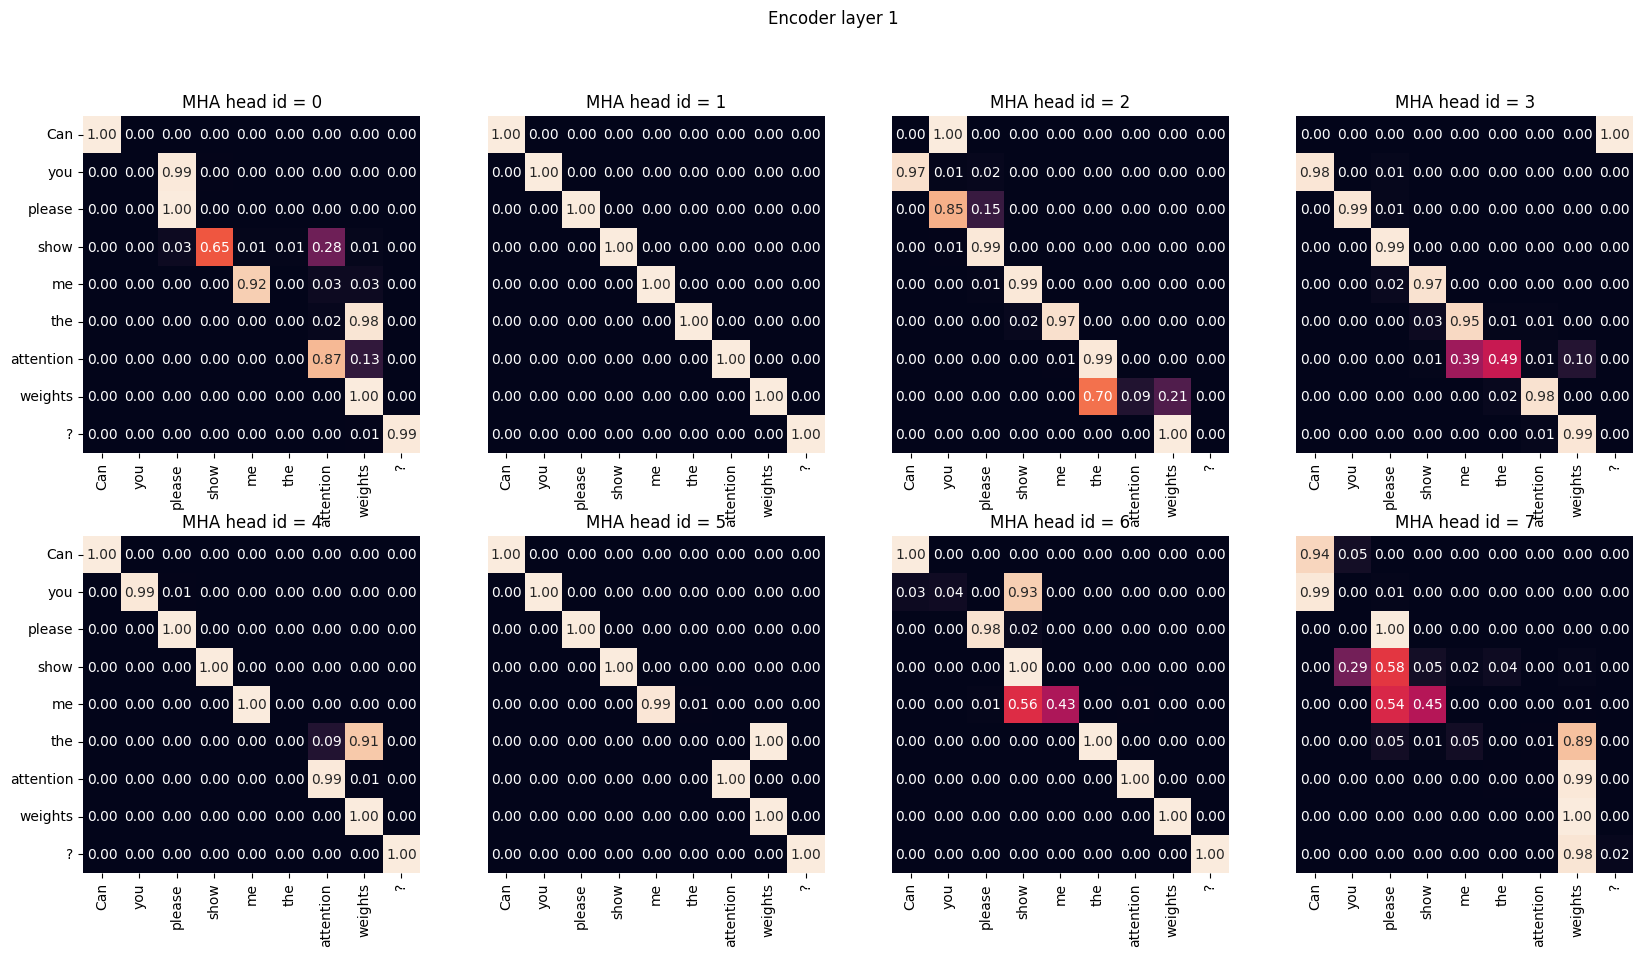

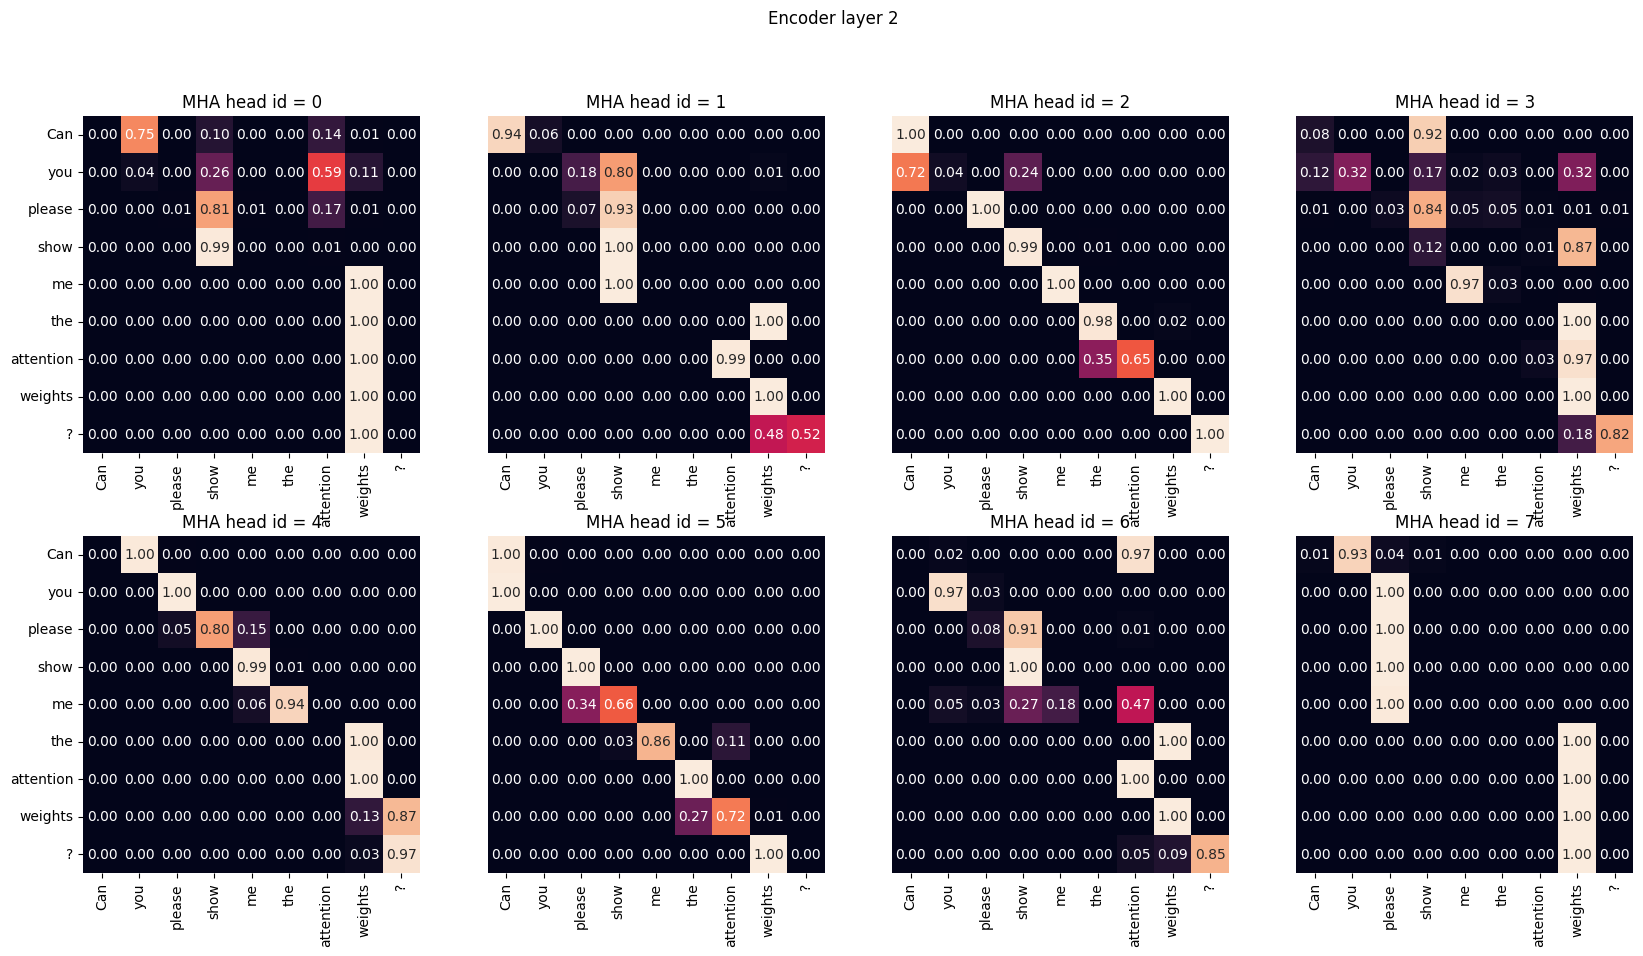

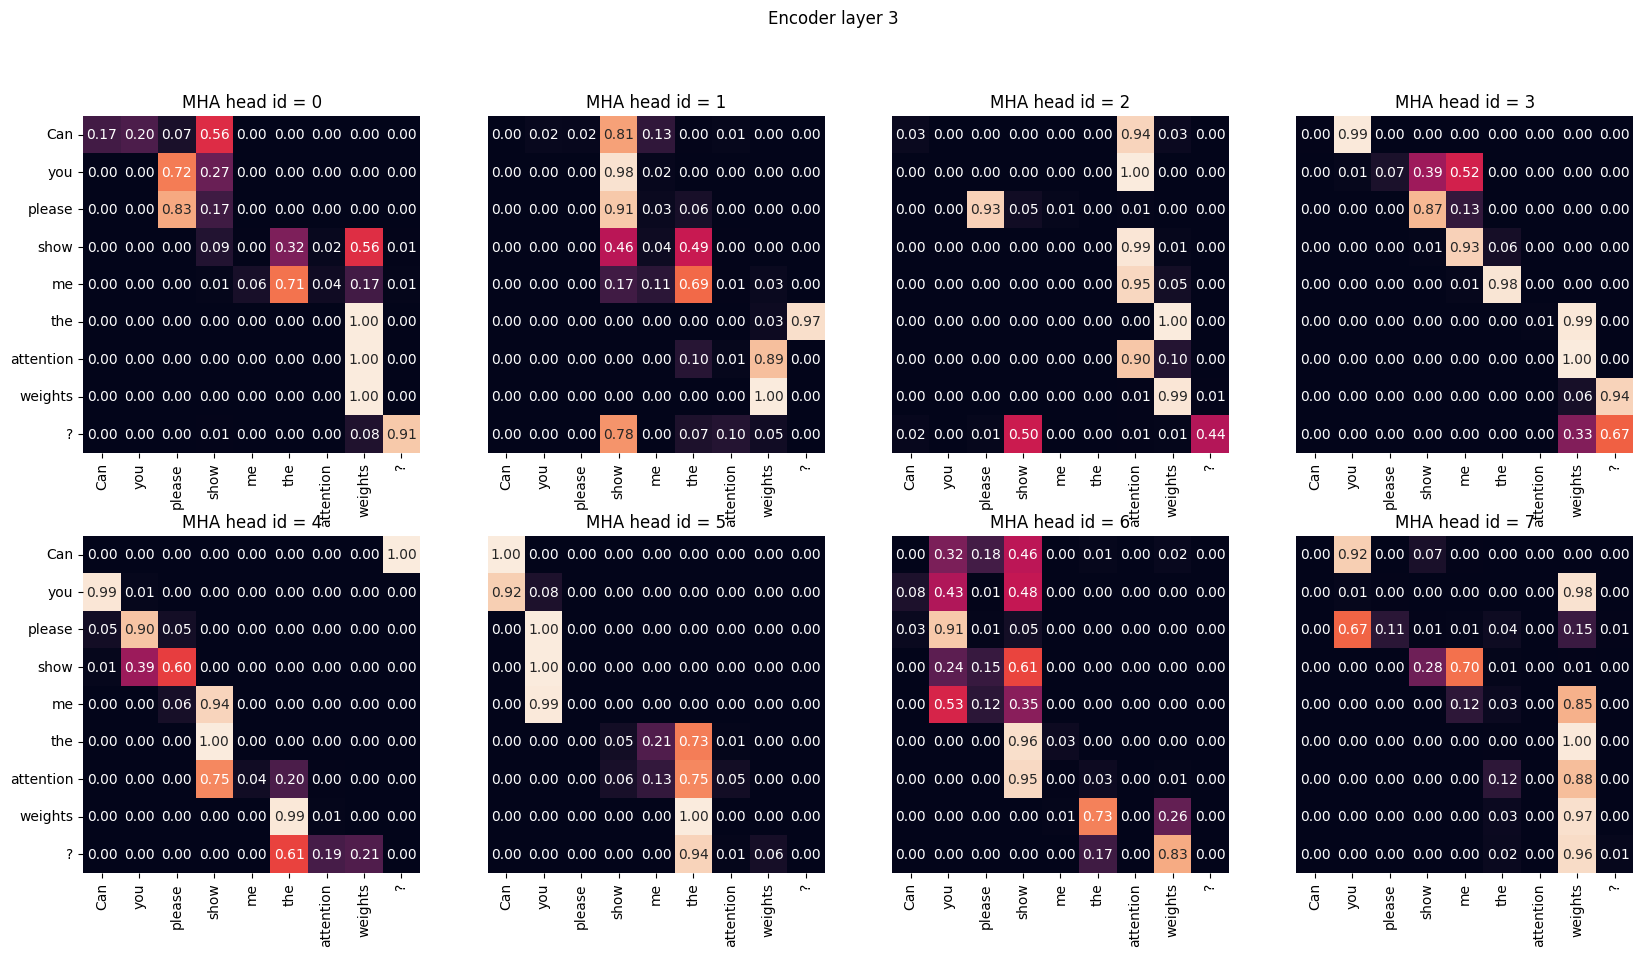

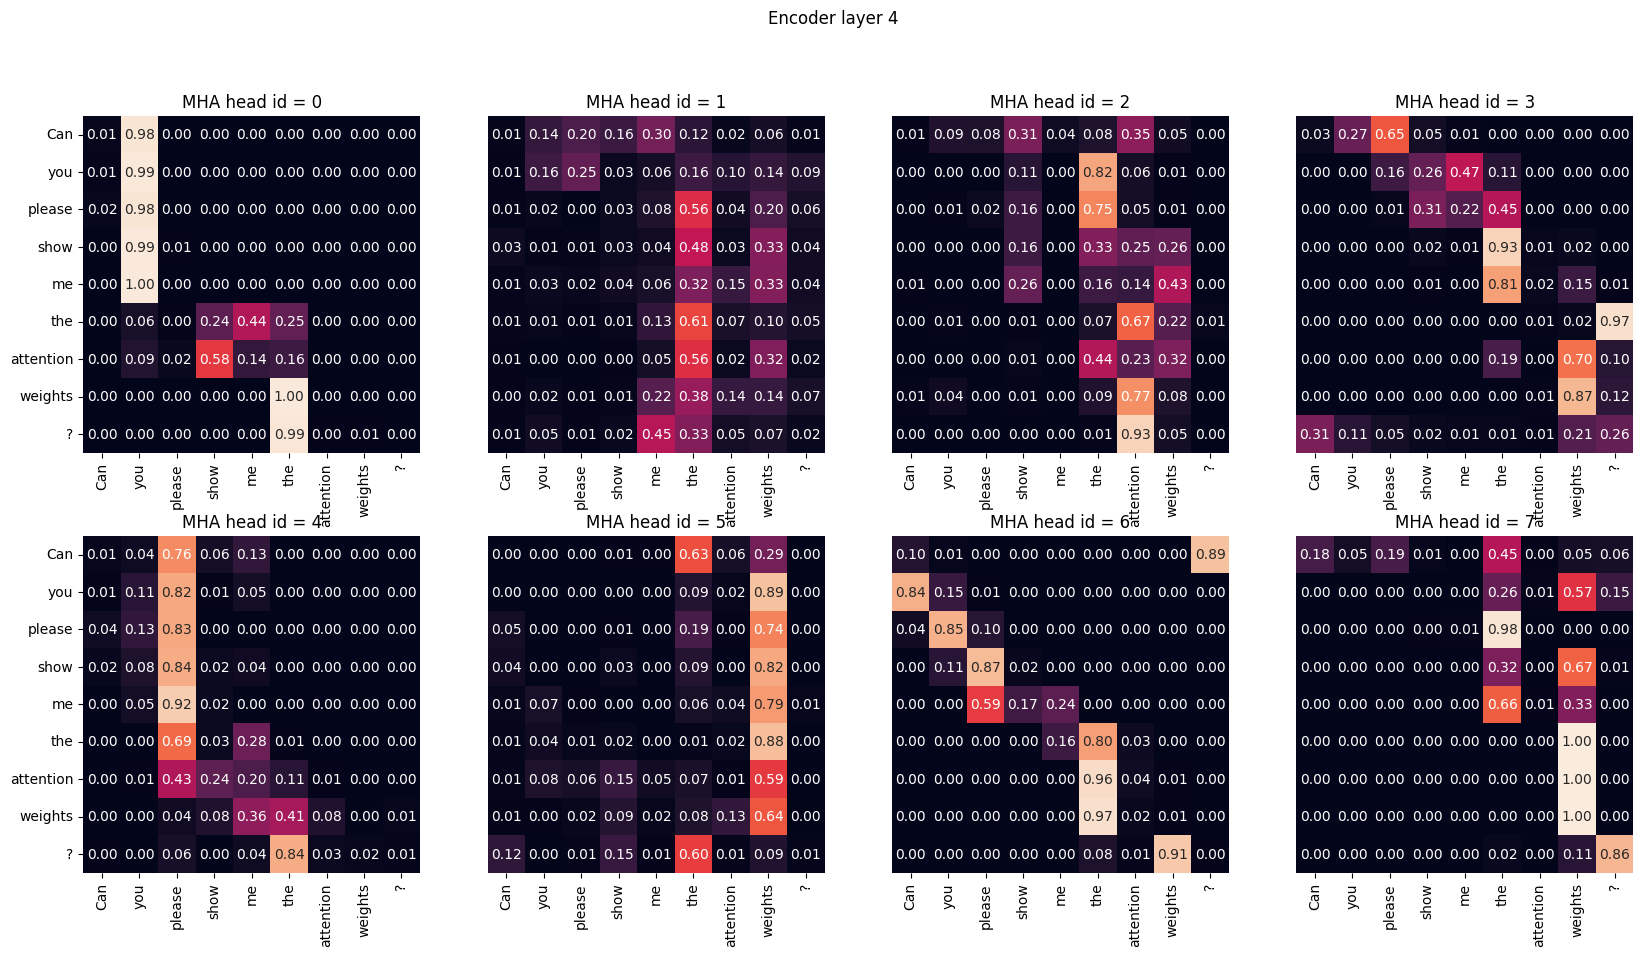

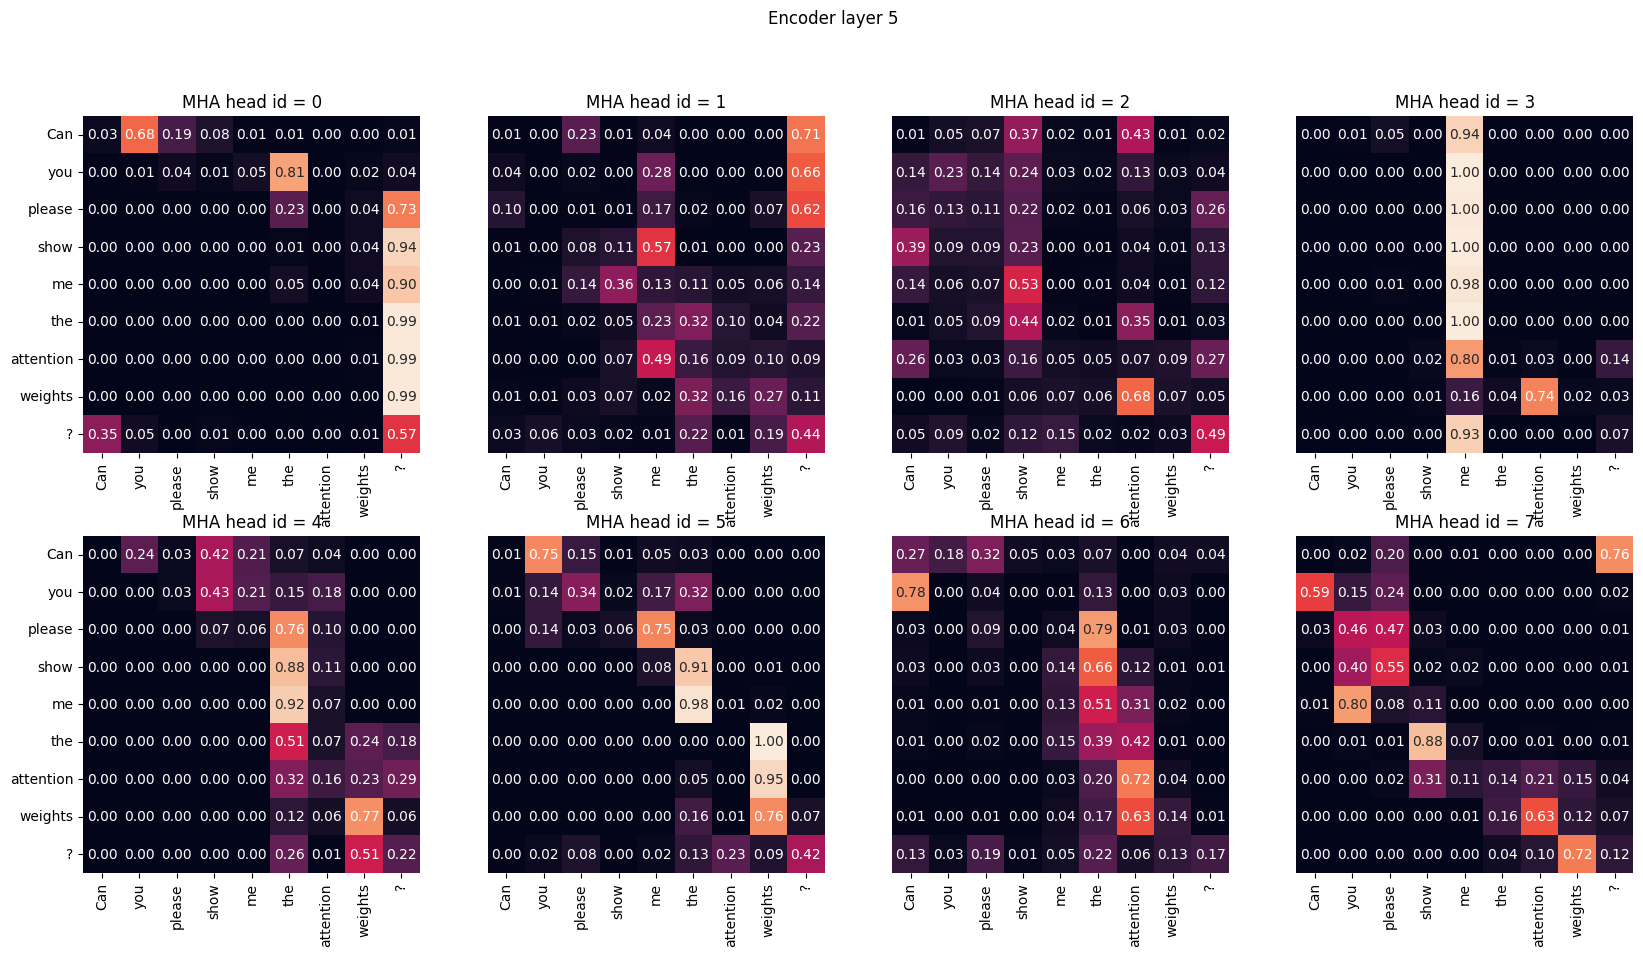

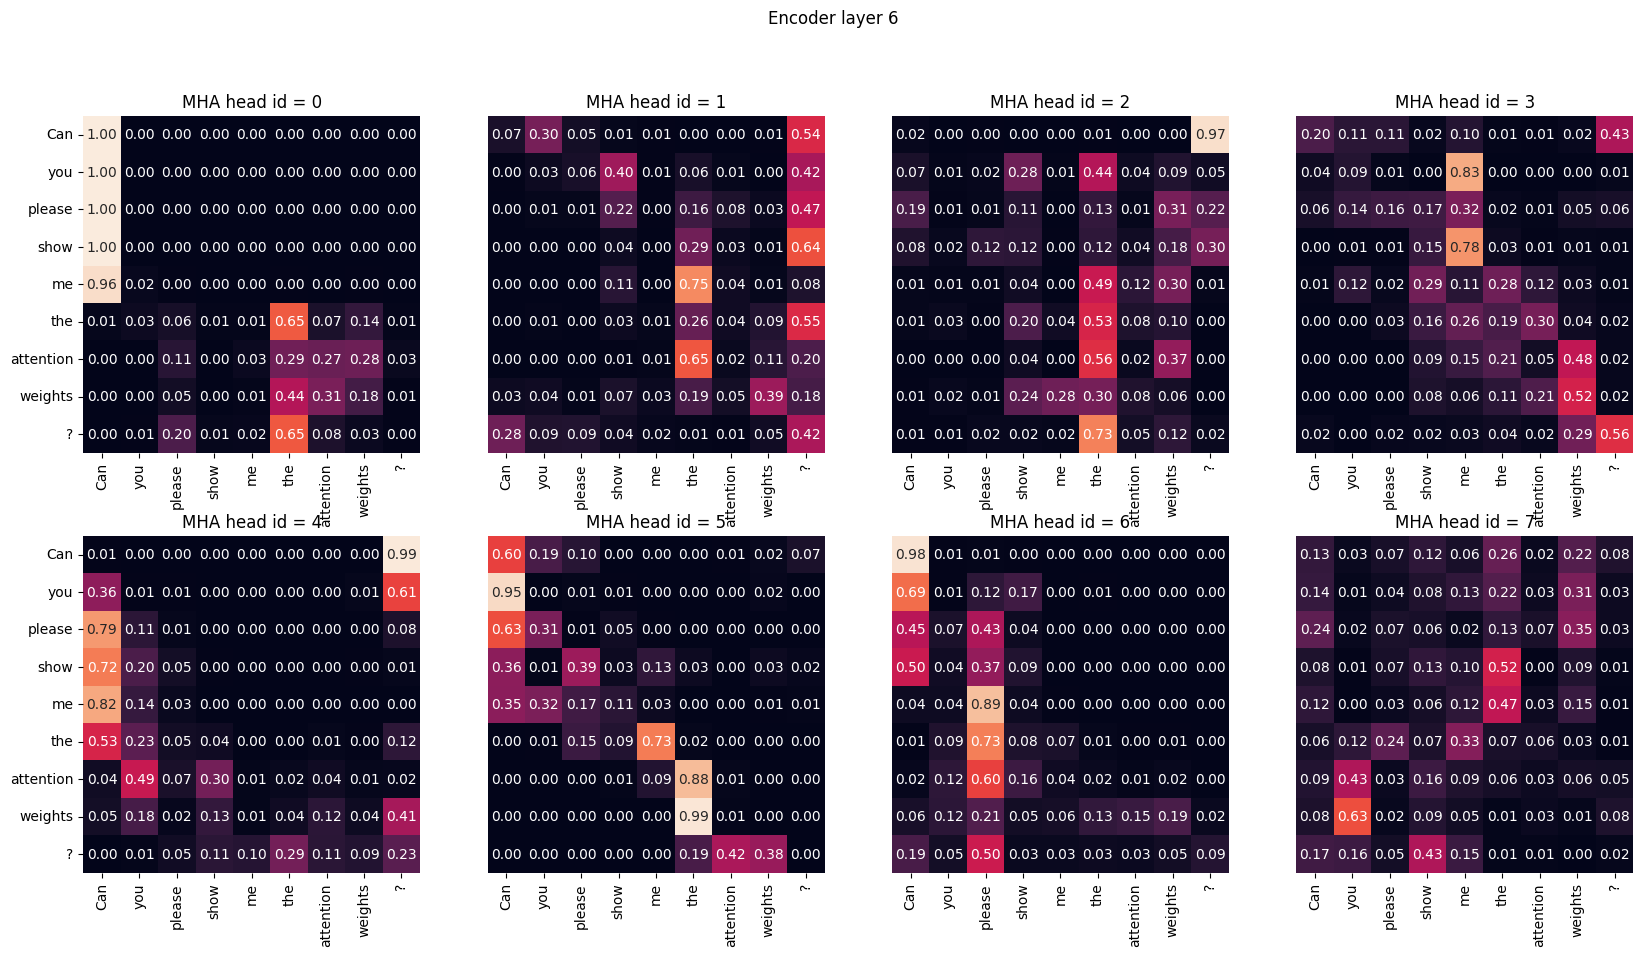

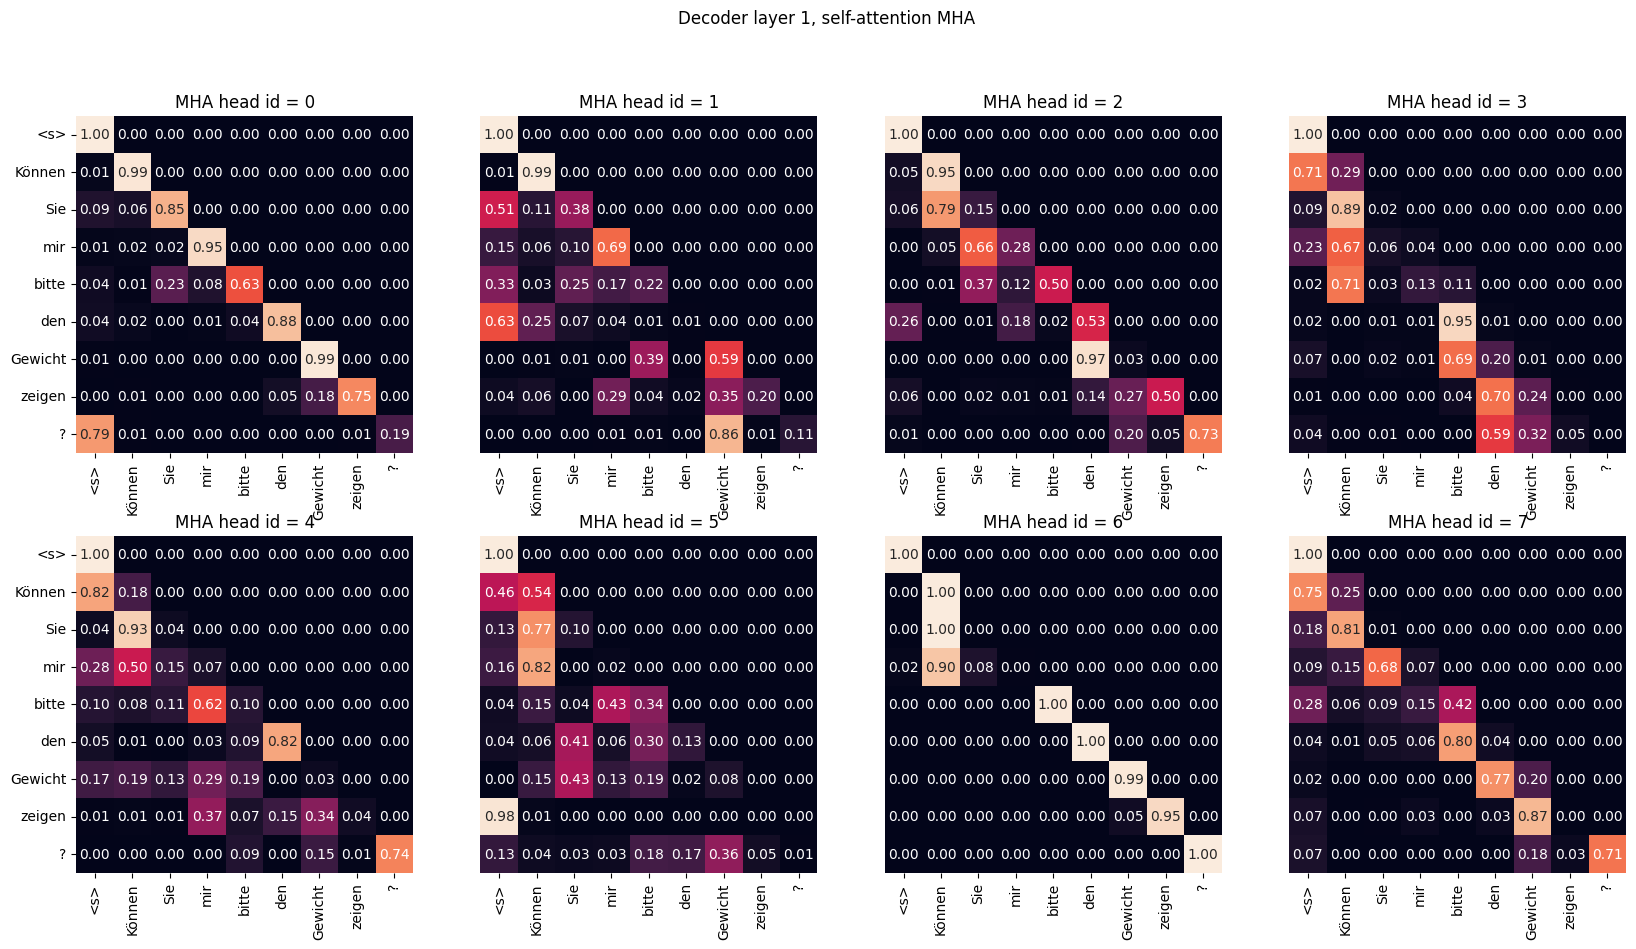

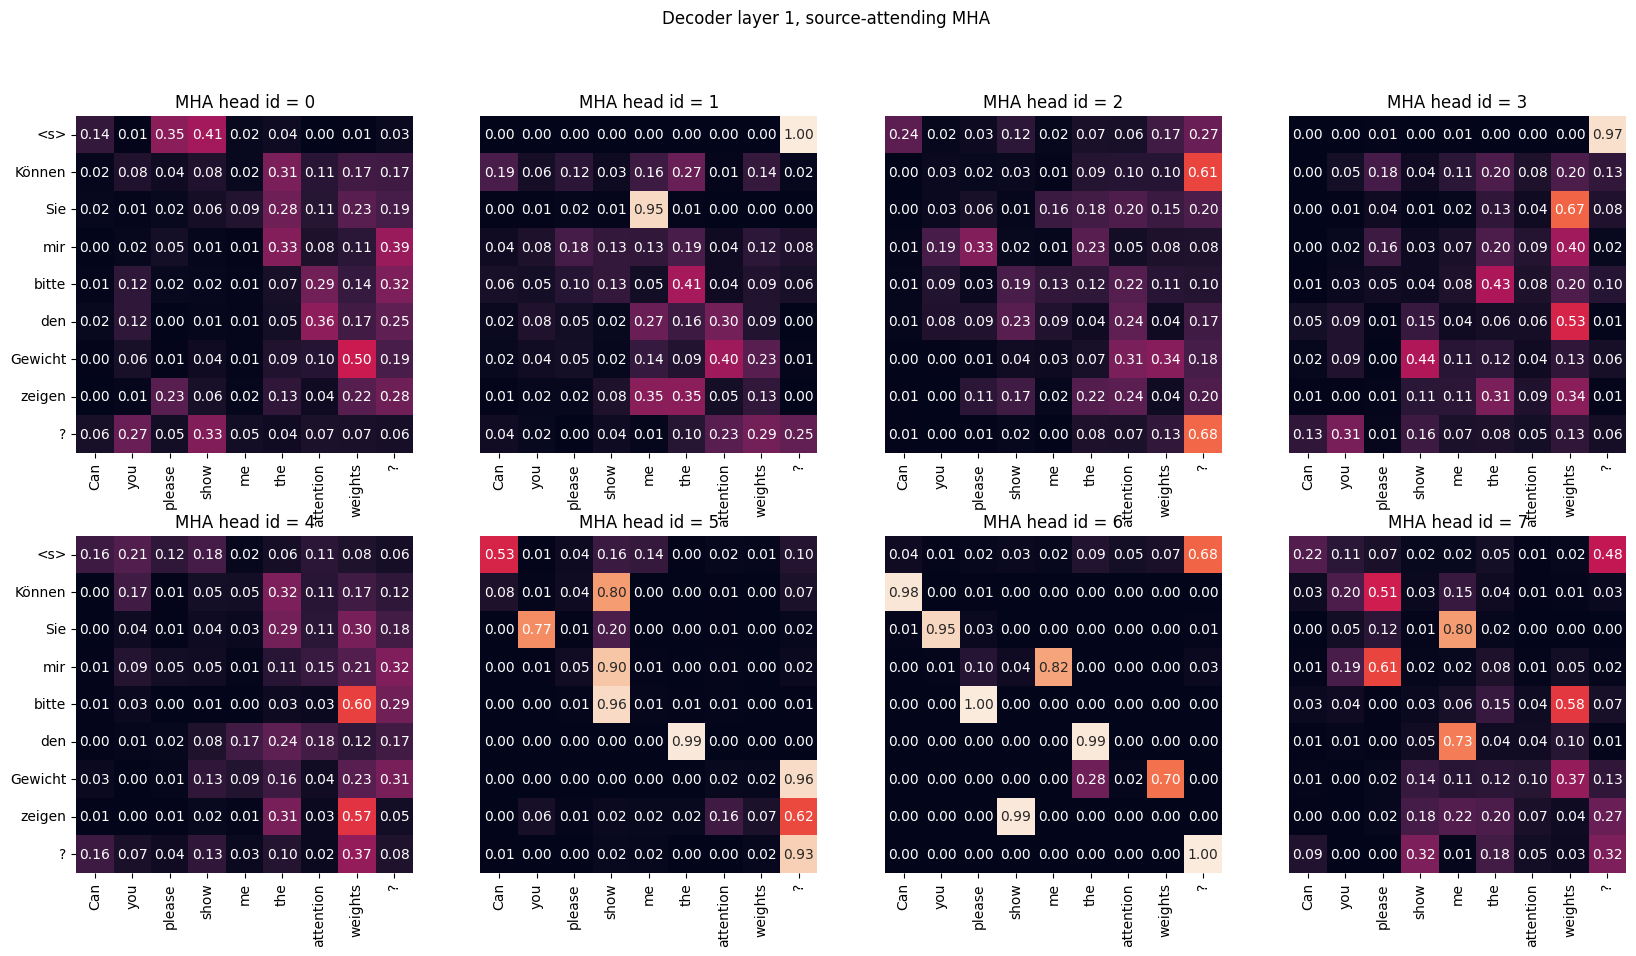

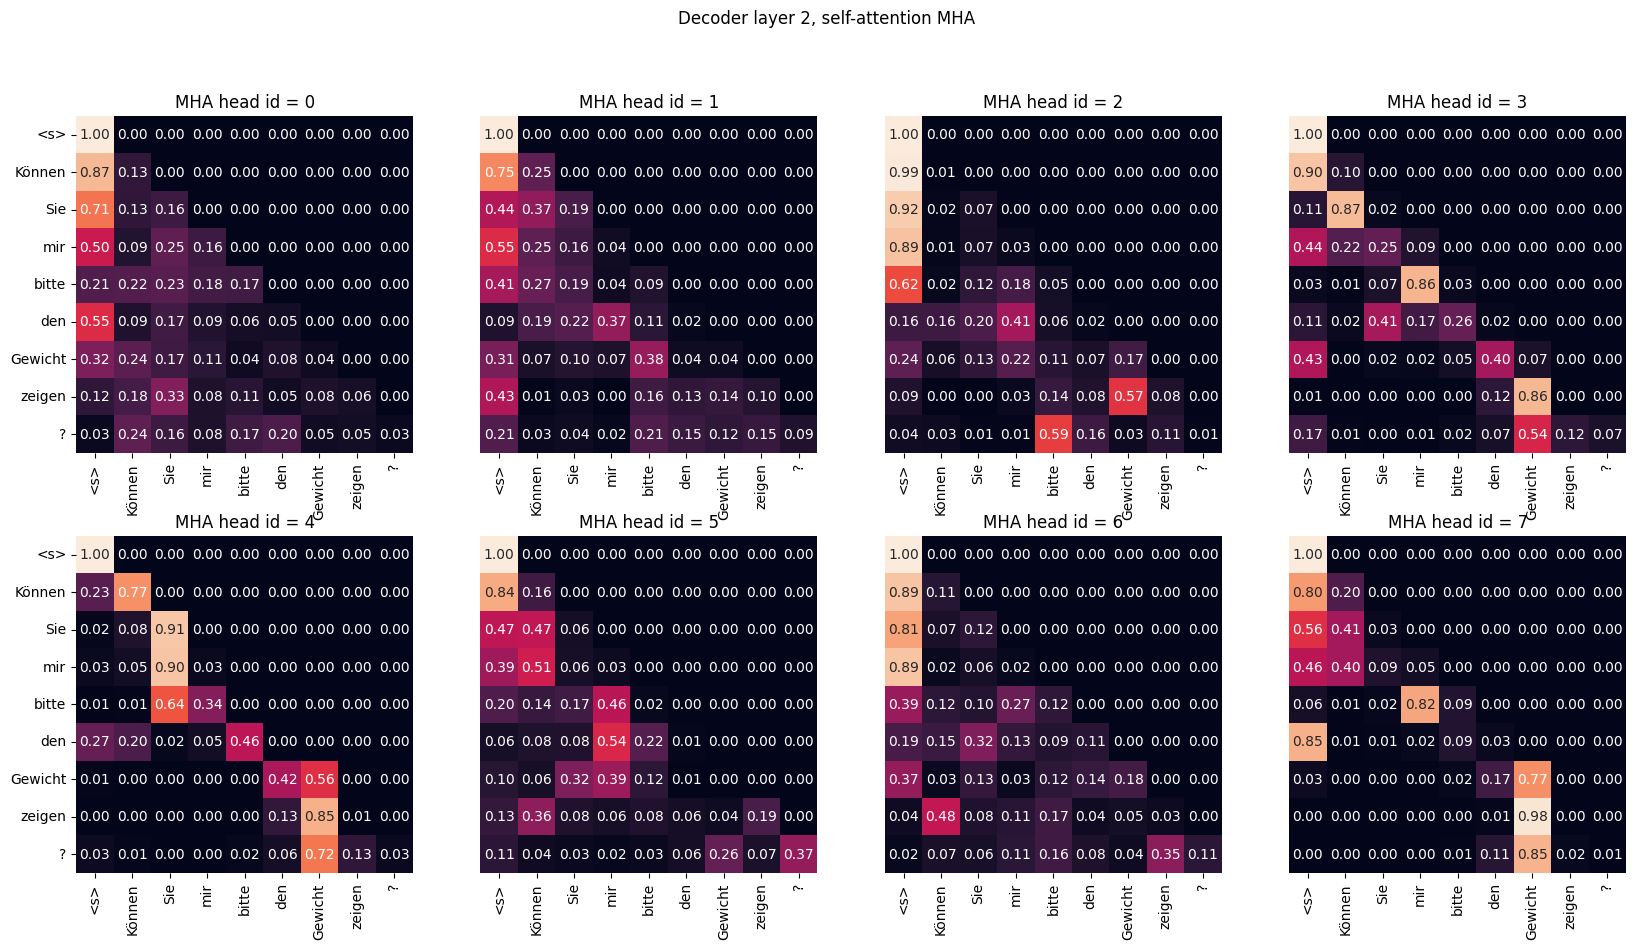

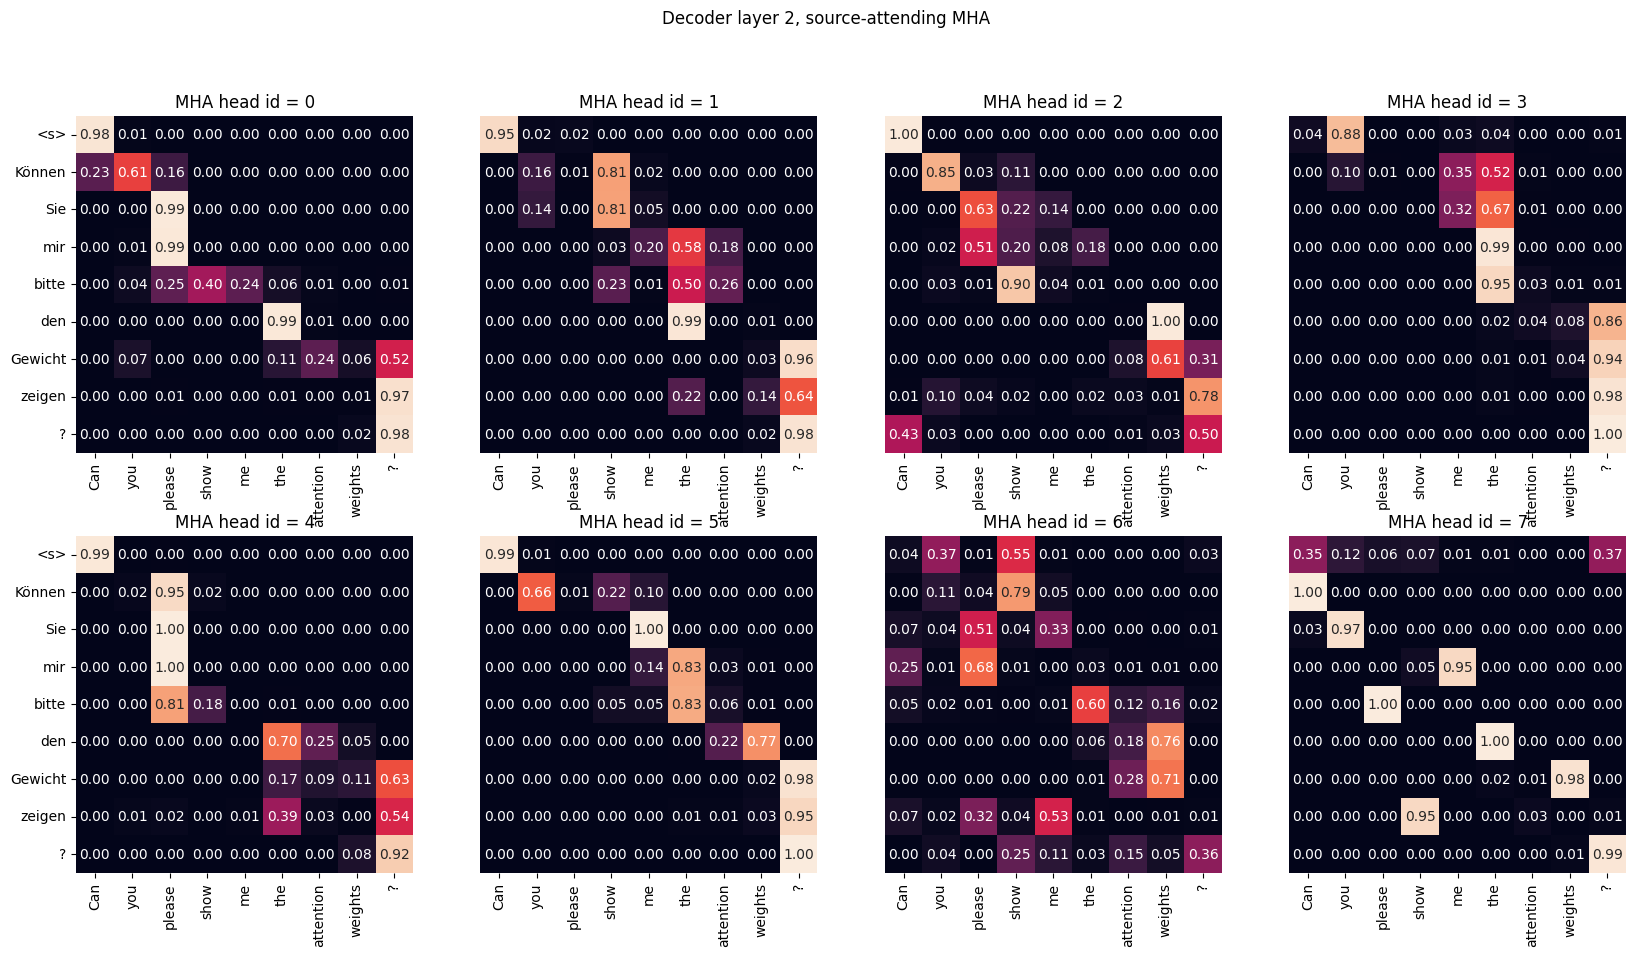

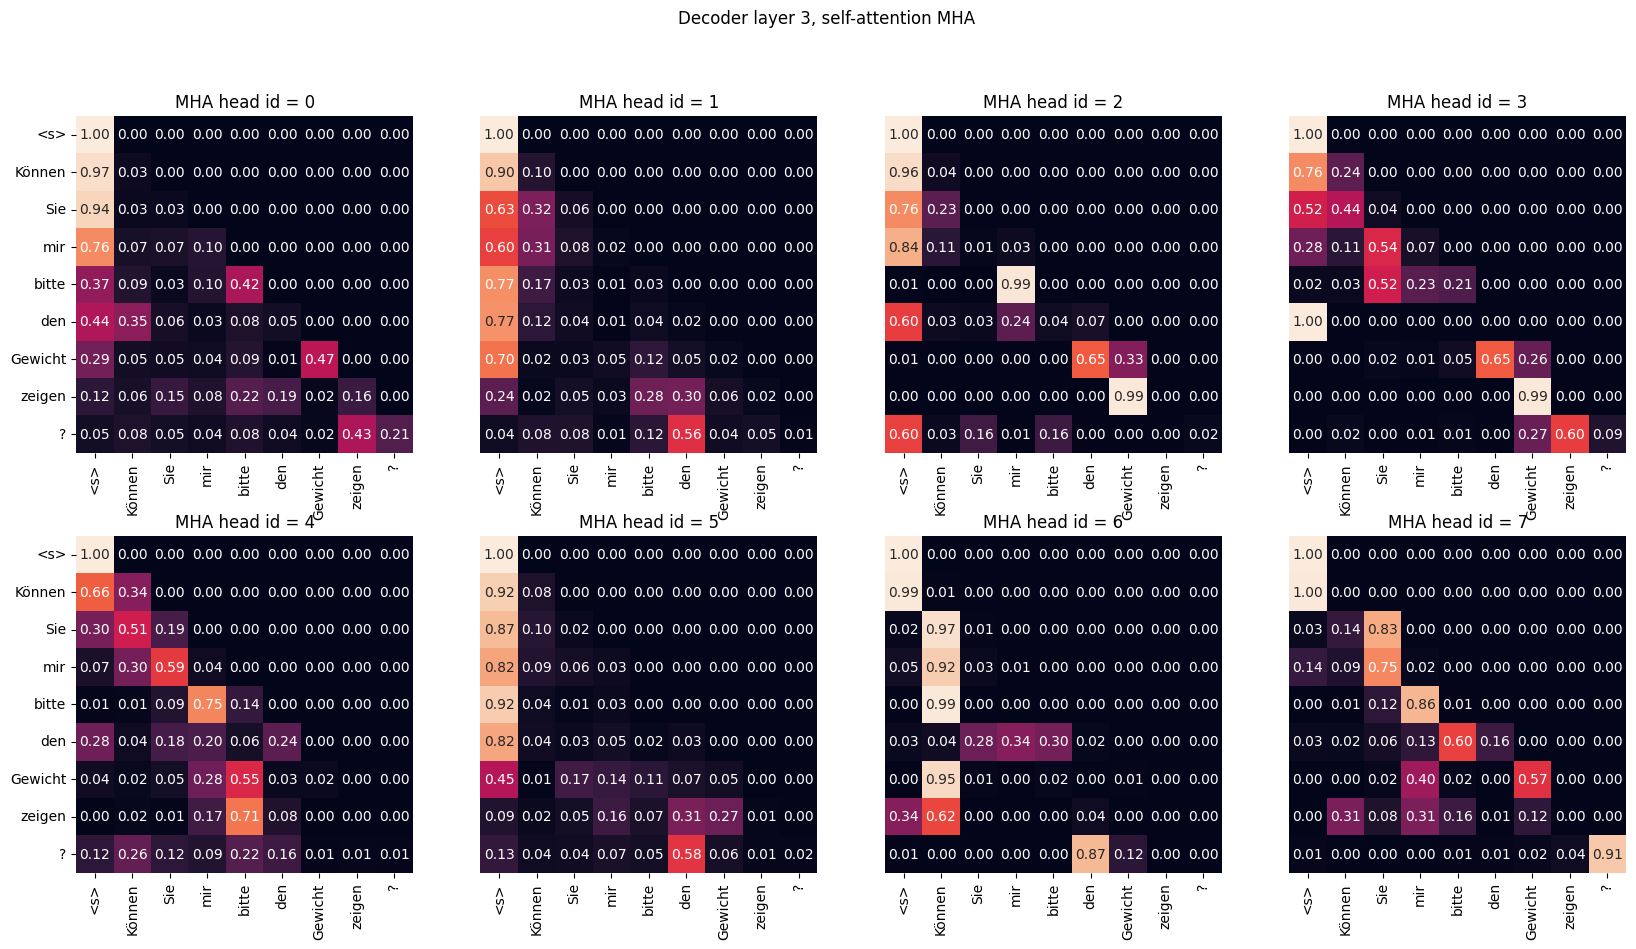

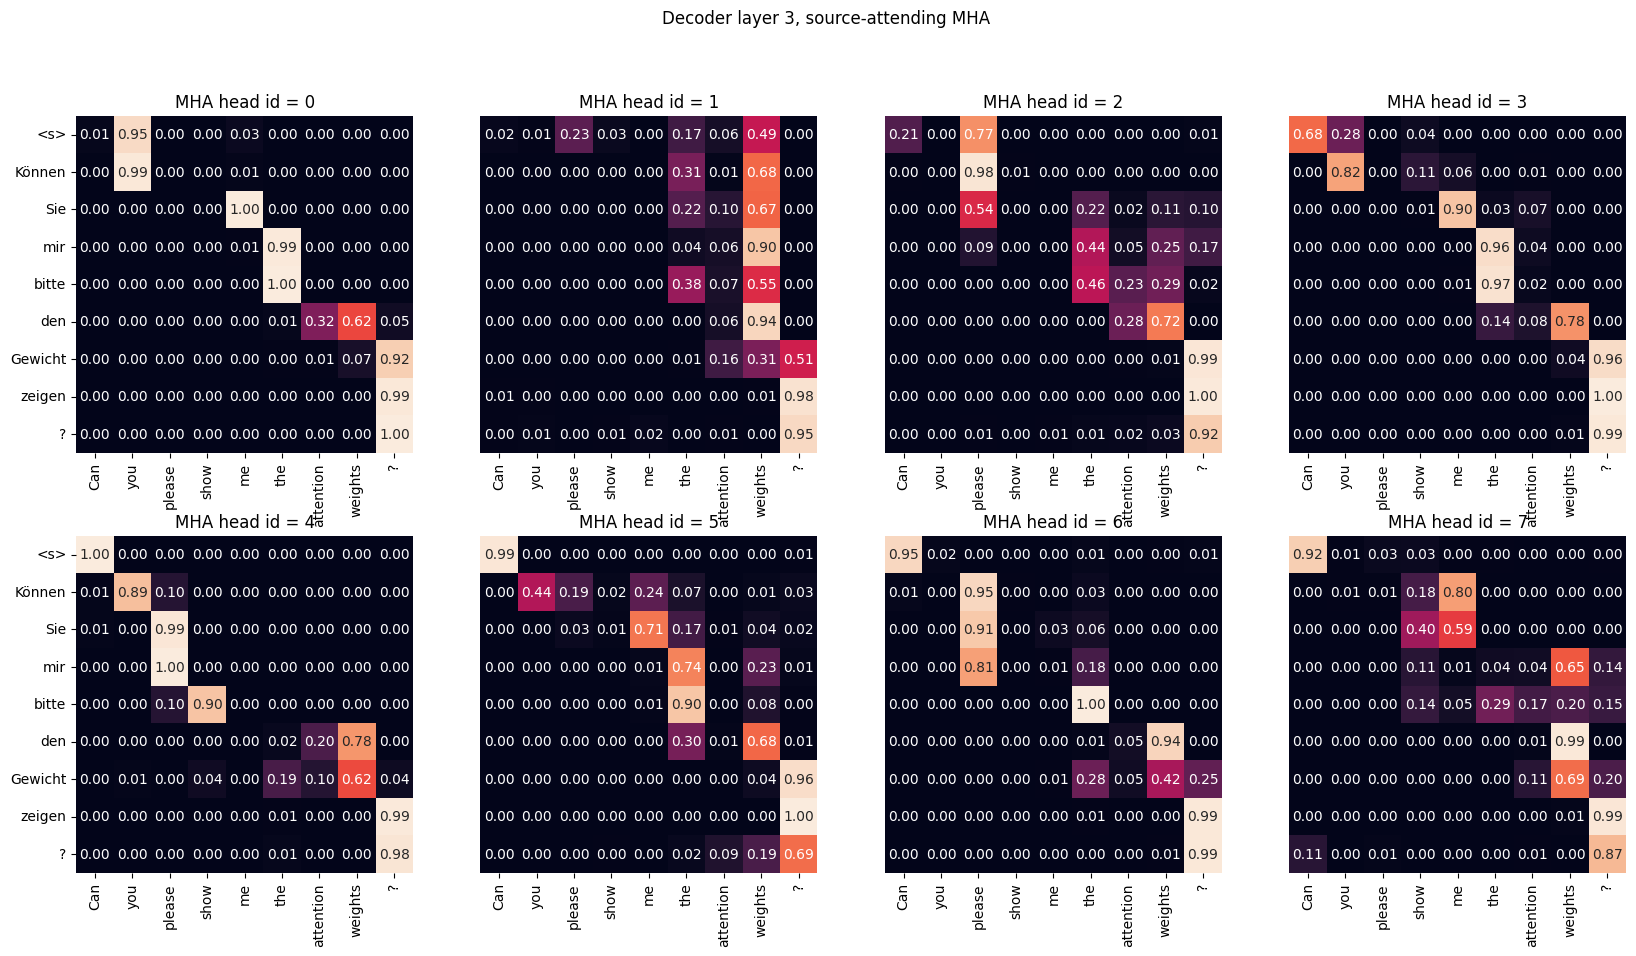

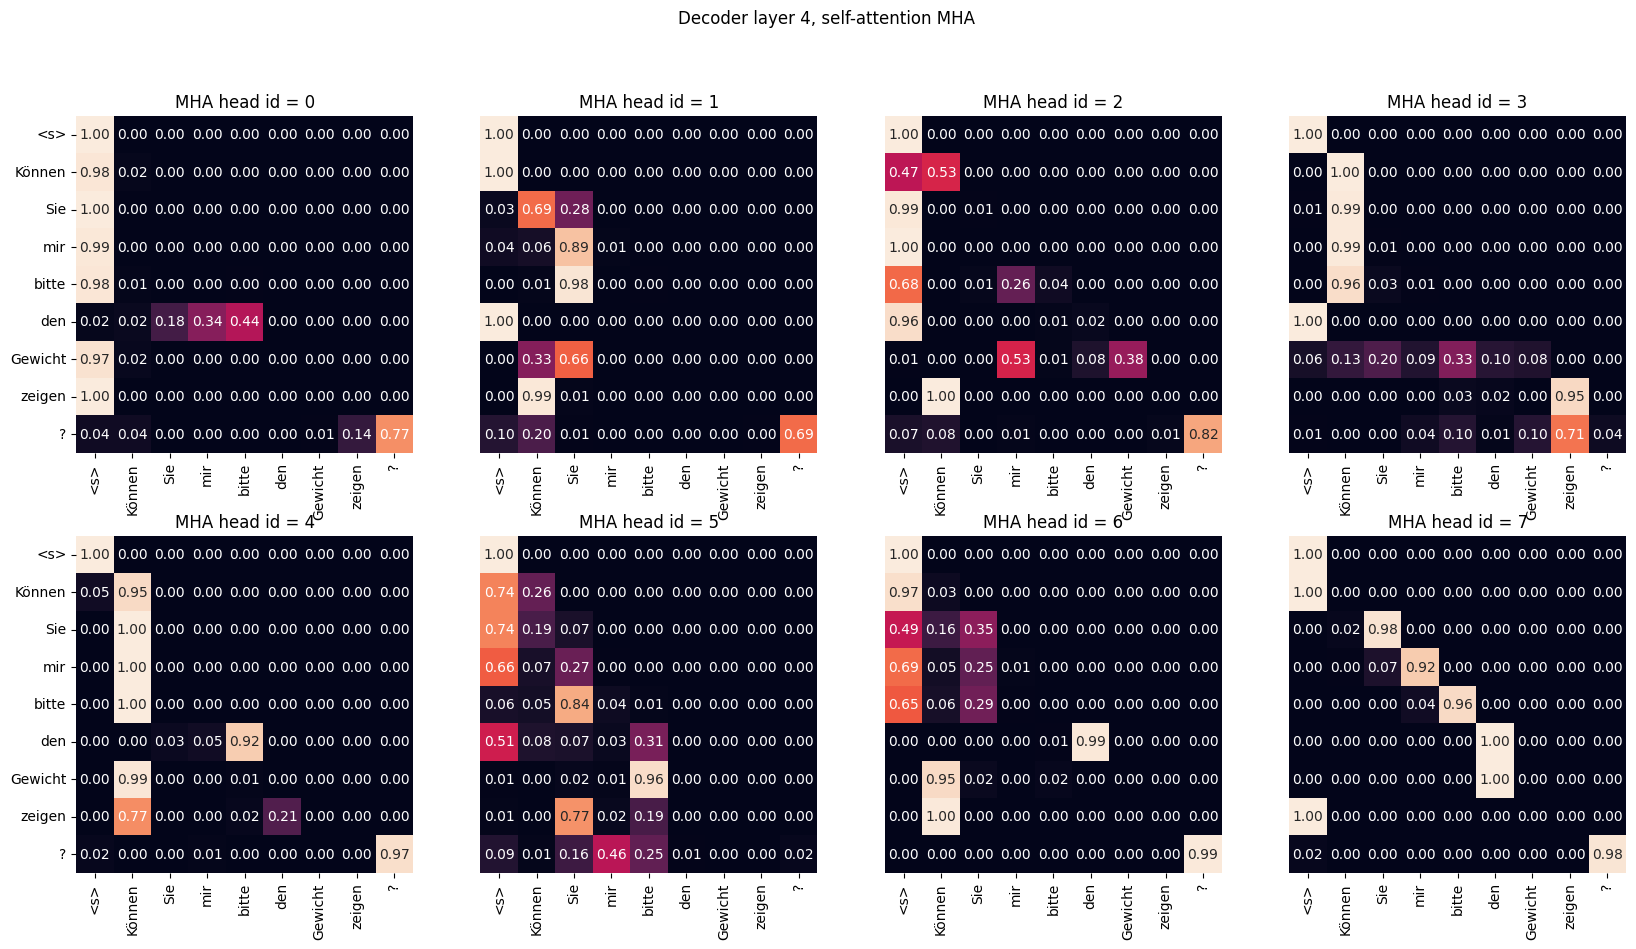

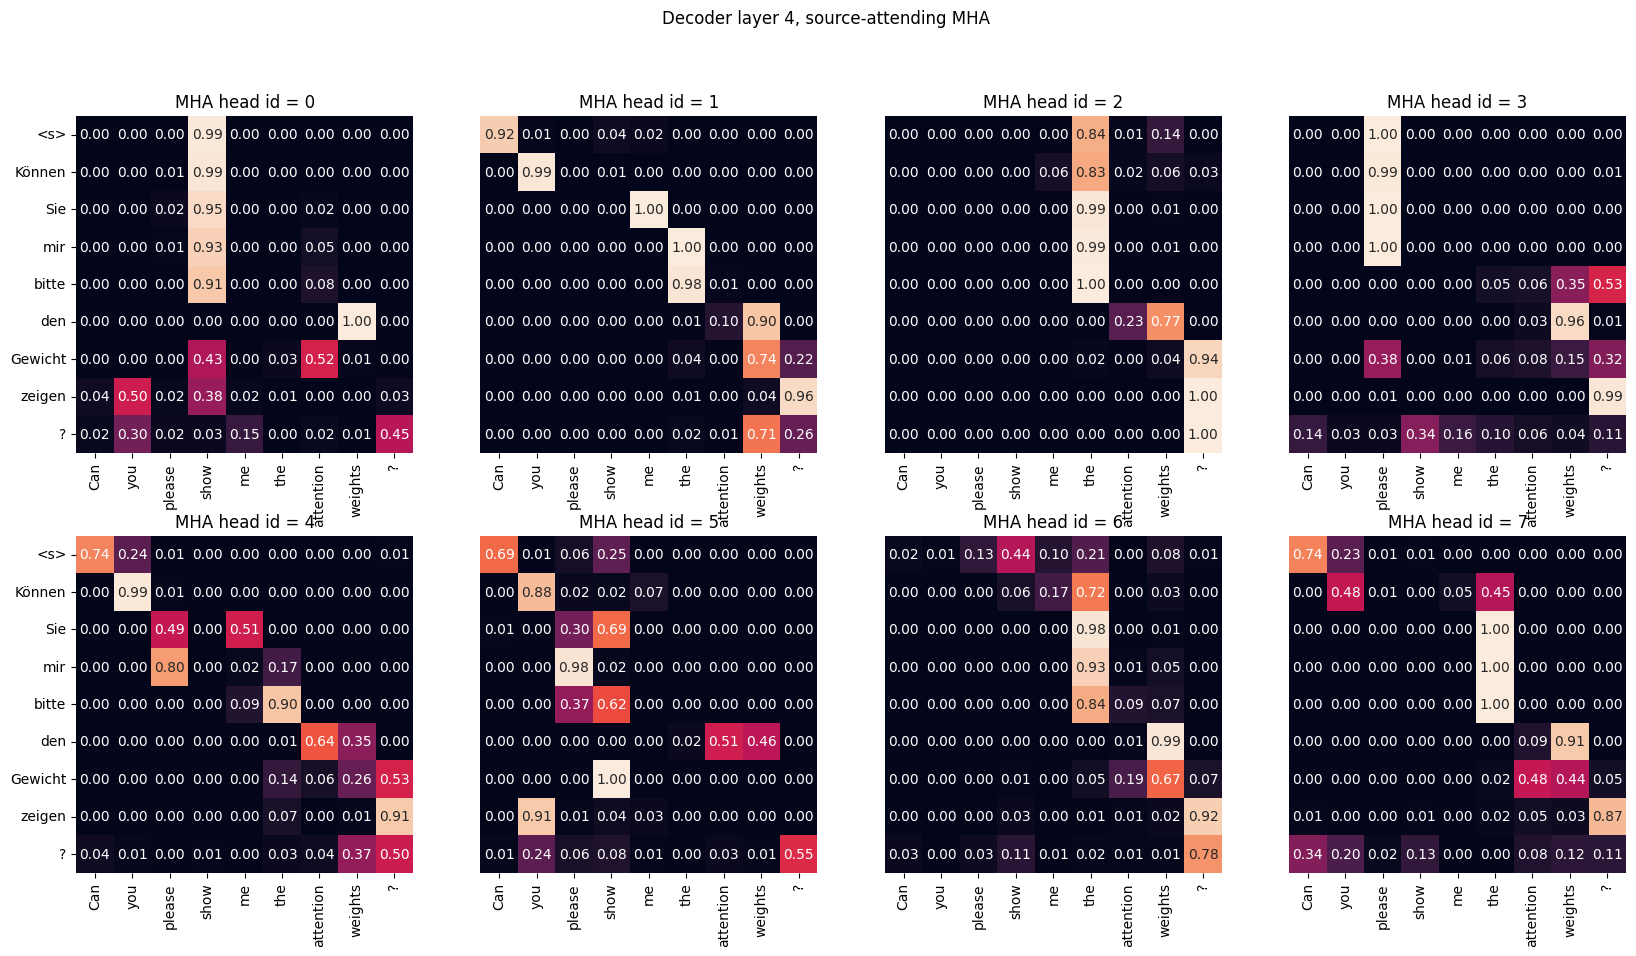

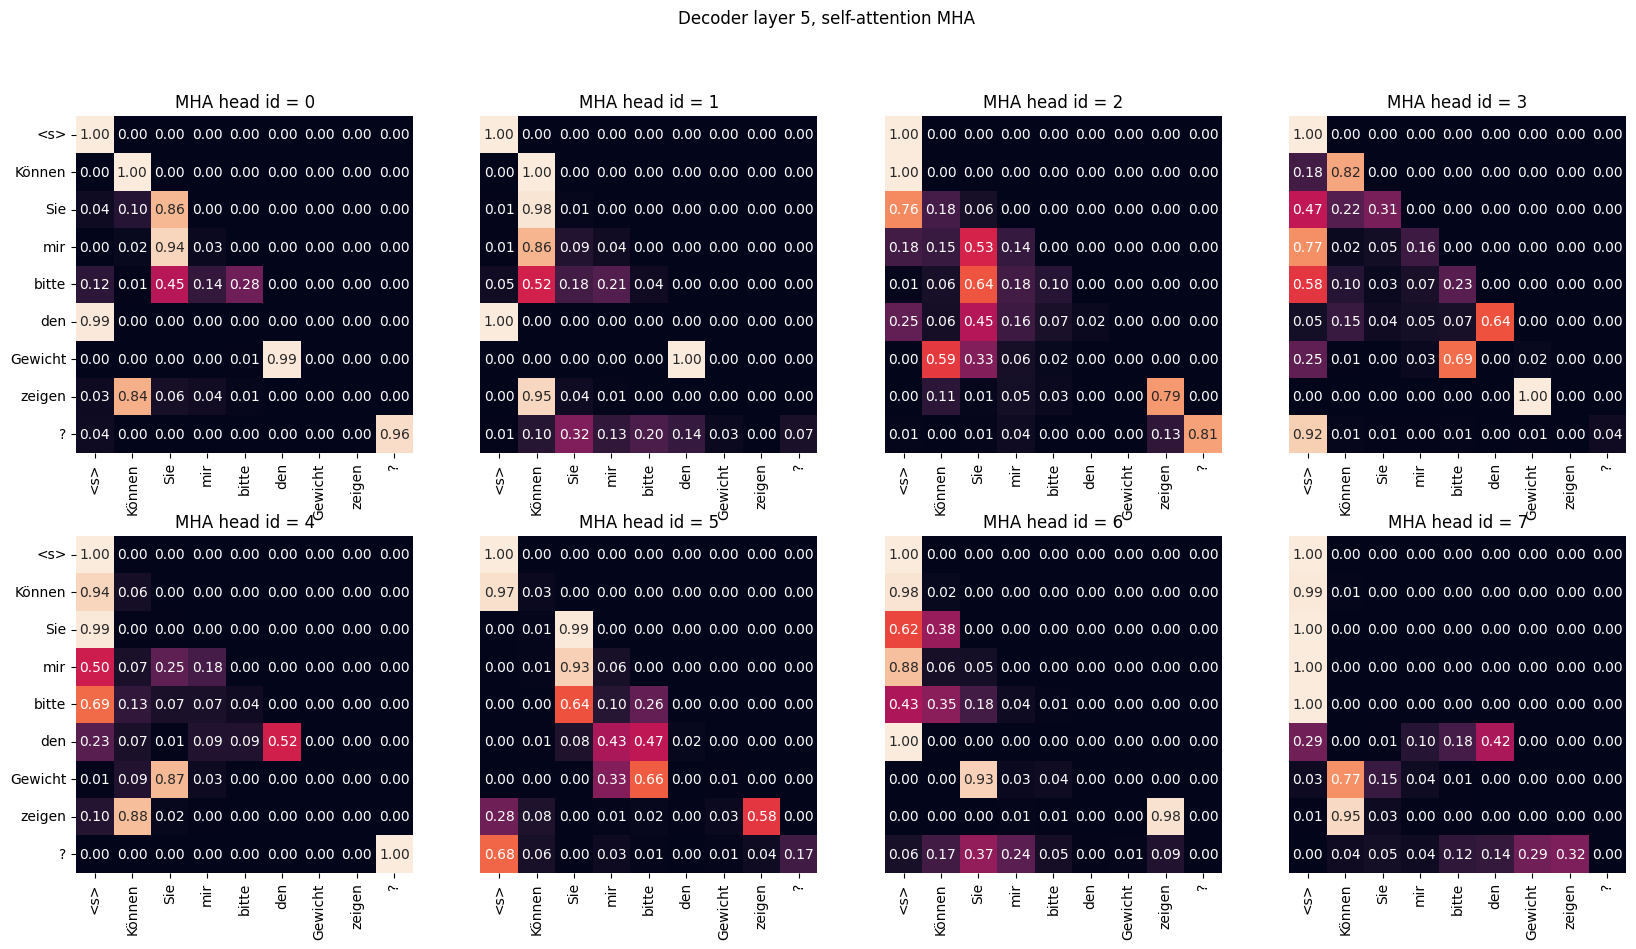

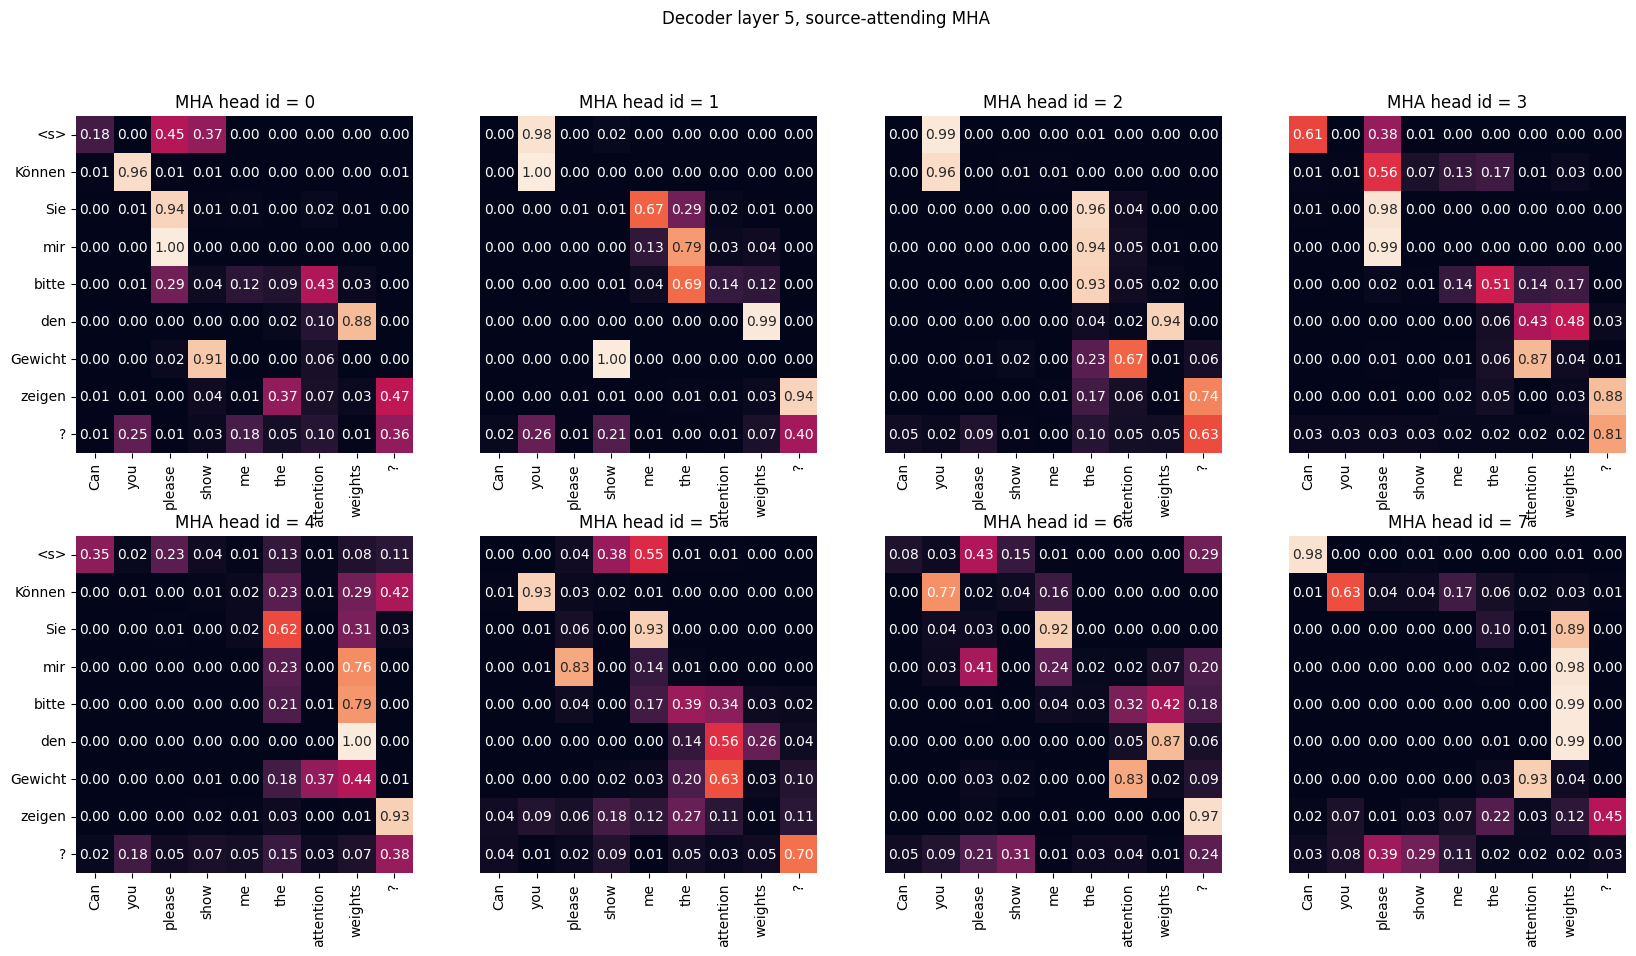

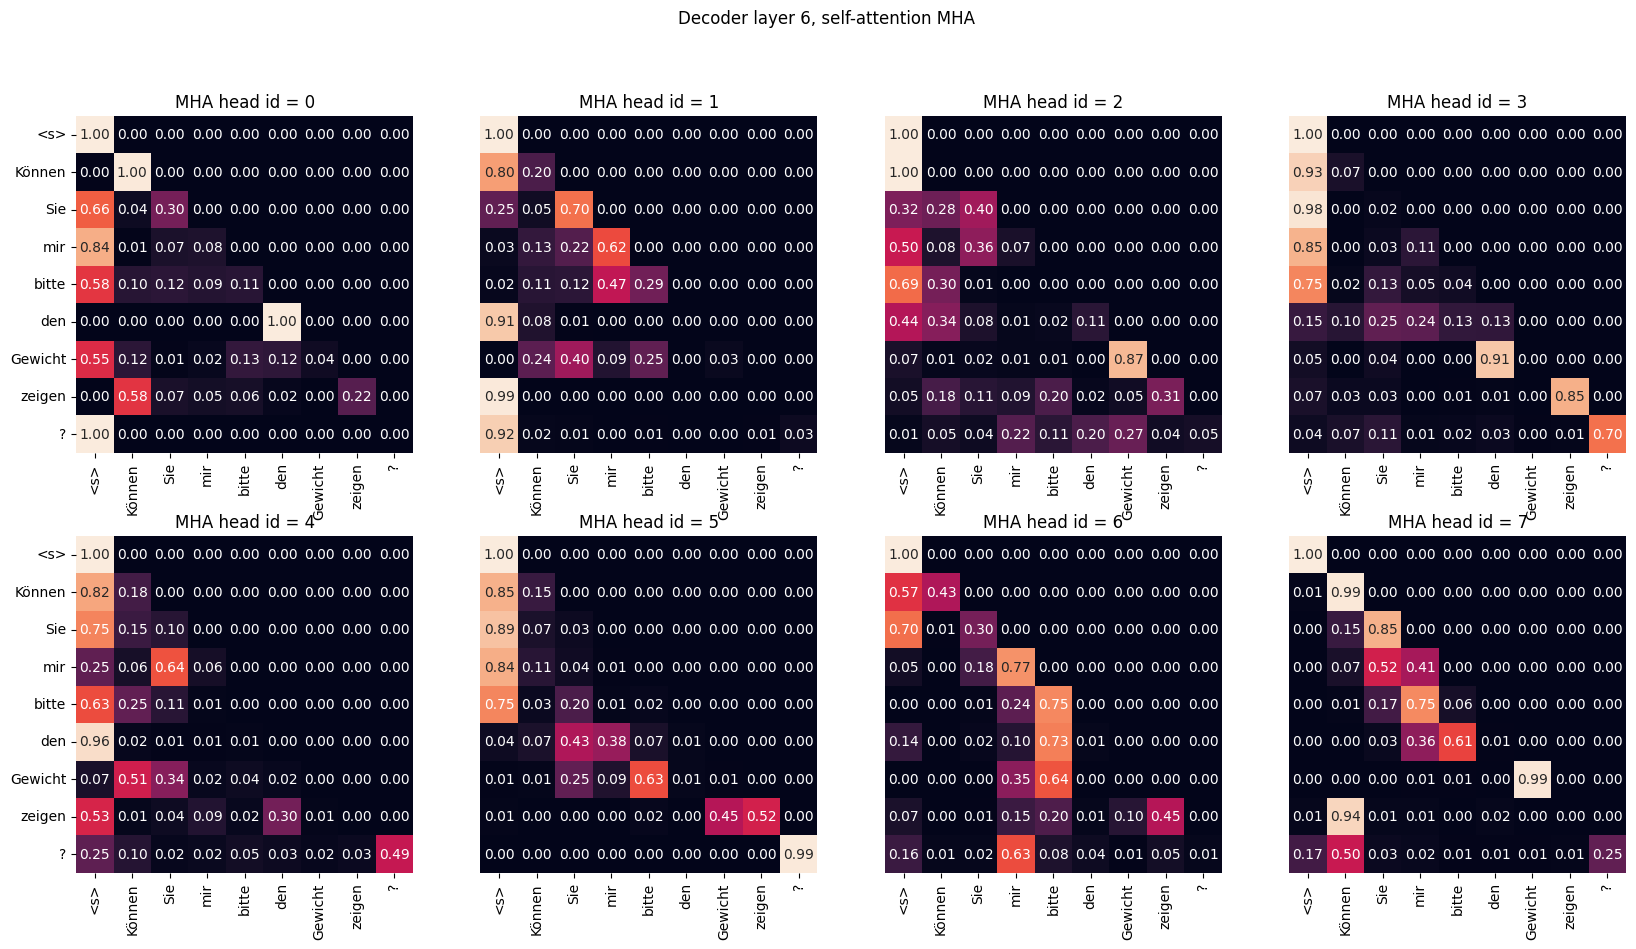

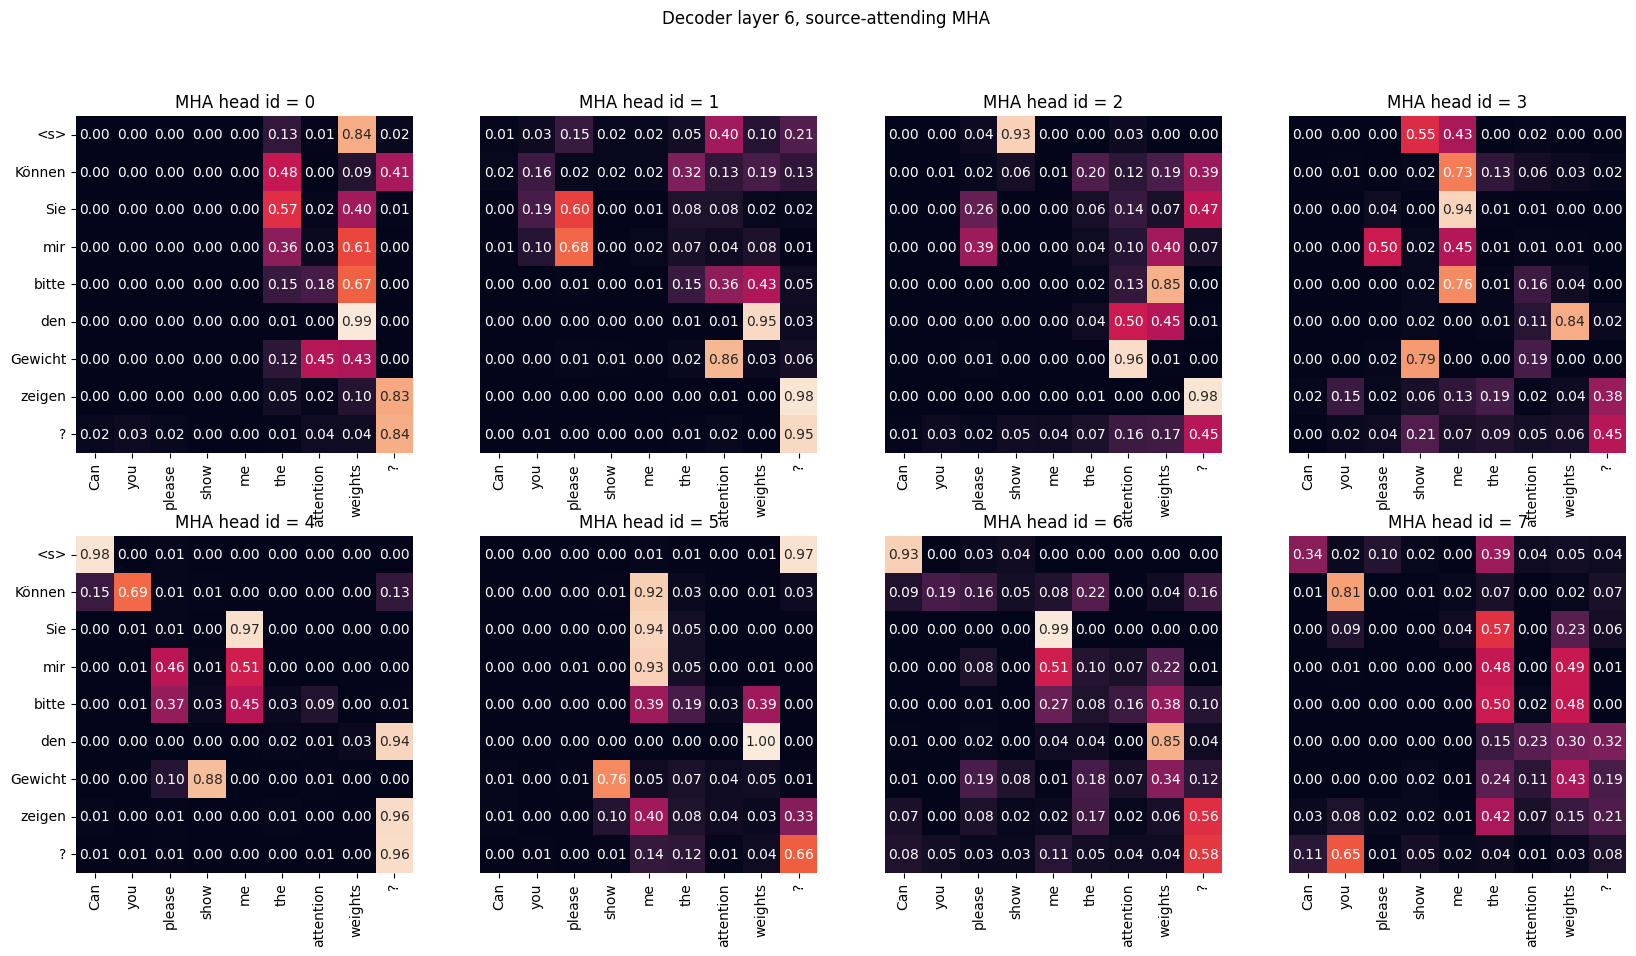

In [ ]:
# This cell forces visualization of attention on a sample sentence.
# Make sure you've already defined the entire Transformer code,
# your "visualize_attention" functions, and the "translate_a_single_sentence"
# function in previous cells.

# 1) Enable attention logging in the Transformer by passing log_attention_weights=True
#    in the model constructor in your inference code (already done if you've set it properly).
# 2) Set visualize_attention=True in the translation_config so that inference triggers visualization.

# Example usage:

# (A) Manually set visualize_attention to True
translation_config['visualize_attention'] = True

# (B) Provide a sentence to translate (English -> German in this example).
translation_config['source_sentence'] = "Can you please show me the attention weights?"

# (C) Call translate_a_single_sentence to run inference AND show the attention plots
translate_a_single_sentence(translation_config)

# If you're running in a Jupyter environment and don't see images,
# ensure you've done `%matplotlib inline` or `%matplotlib notebook` at the top.


# Testing the Translation

In [30]:
import os
import gdown

def download_file(url, output):
    """Download a file from the given URL to the output path if it does not already exist."""
    if os.path.exists(output):
        print(f"[INFO] '{output}' already exists.")
    else:
        print(f"[INFO] Downloading '{output}' from {url} ...")
        gdown.download(url, output, quiet=False)
        if os.path.exists(output):
            print(f"[INFO] Successfully downloaded '{output}'.")
        else:
            print(f"[ERROR] Failed to download '{output}'.")

def main():
    # Pretrained model weights (English -> German)
    model_url = "https://drive.google.com/uc?id=1BxnqcktsPDR738mVQuKc6hS1XBwPObfg&export=download"
    model_output = "iwslt_e2g.pth"

    # Source vocabulary file
    src_vocab_url = "https://drive.google.com/uc?id=1s2IpXPhm3aTwNO8KSCjD-_0CiWY_hha9&export=download"
    src_vocab_output = "src_vocab.pkl"

    # Target vocabulary file
    trg_vocab_url = "https://drive.google.com/uc?id=1ZN6B0Sq9xviDu5tti4YX5Q59cQy1hIjV&export=download"
    trg_vocab_output = "trg_vocab.pkl"

    download_file(model_url, model_output)
    download_file(src_vocab_url, src_vocab_output)
    download_file(trg_vocab_url, trg_vocab_output)

if __name__ == "__main__":
    main()


[INFO] Downloading 'iwslt_e2g.pth' from https://drive.google.com/uc?id=1BxnqcktsPDR738mVQuKc6hS1XBwPObfg&export=download ...


Downloading...
From (original): https://drive.google.com/uc?id=1BxnqcktsPDR738mVQuKc6hS1XBwPObfg&export=download
From (redirected): https://drive.google.com/uc?id=1BxnqcktsPDR738mVQuKc6hS1XBwPObfg&export=download&confirm=t&uuid=beb30da2-0090-43ae-9662-5d183568054a
To: /content/iwslt_e2g.pth
100%|██████████| 527M/527M [00:11<00:00, 46.2MB/s]


[INFO] Successfully downloaded 'iwslt_e2g.pth'.
[INFO] Downloading 'src_vocab.pkl' from https://drive.google.com/uc?id=1s2IpXPhm3aTwNO8KSCjD-_0CiWY_hha9&export=download ...


Downloading...
From: https://drive.google.com/uc?id=1s2IpXPhm3aTwNO8KSCjD-_0CiWY_hha9&export=download
To: /content/src_vocab.pkl
100%|██████████| 501k/501k [00:00<00:00, 111MB/s]


[INFO] Successfully downloaded 'src_vocab.pkl'.
[INFO] Downloading 'trg_vocab.pkl' from https://drive.google.com/uc?id=1ZN6B0Sq9xviDu5tti4YX5Q59cQy1hIjV&export=download ...


Downloading...
From: https://drive.google.com/uc?id=1ZN6B0Sq9xviDu5tti4YX5Q59cQy1hIjV&export=download
To: /content/trg_vocab.pkl
100%|██████████| 972k/972k [00:00<00:00, 136MB/s]

[INFO] Successfully downloaded 'trg_vocab.pkl'.


In [31]:
import os
import pickle
import torch
import argparse
from torch.hub import download_url_to_file

# Assuming the following constants and functions are defined/imported:
# PAD_TOKEN, BASELINE_MODEL_DIMENSION, BASELINE_MODEL_NUMBER_OF_HEADS,
# BASELINE_MODEL_NUMBER_OF_LAYERS, BASELINE_MODEL_DROPOUT_PROB, DatasetType, LanguageDirection,
# Transformer, get_datasets_and_vocabs, get_masks_and_count_tokens_src, greedy_decoding, visualize_attention,
# print_model_metadata

def load_vocab(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def try_load_vocab_inference():
    """
    Attempt to load source/target vocabularies from local files.
    If not found, download them from the provided Google Drive links.
    Returns (src_vocab_dict, trg_vocab_dict, loaded_from).
    """
    src_vocab_local = "src_vocab.pkl"
    trg_vocab_local = "trg_vocab.pkl"

    # Google Drive direct download URLs for the vocab files:
    src_vocab_url = "https://drive.google.com/uc?id=1s2IpXPhm3aTwNO8KSCjD-_0CiWY_hha9&export=download"
    trg_vocab_url = "https://drive.google.com/uc?id=1ZN6B0Sq9xviDu5tti4YX5Q59cQy1hIjV&export=download"

    if not os.path.exists(src_vocab_local):
        print("Downloading src_vocab.pkl from Google Drive...")
        download_url_to_file(src_vocab_url, src_vocab_local)
    if not os.path.exists(trg_vocab_local):
        print("Downloading trg_vocab.pkl from Google Drive...")
        download_url_to_file(trg_vocab_url, trg_vocab_local)

    return load_vocab(src_vocab_local), load_vocab(trg_vocab_local), os.getcwd()

def get_latest_model_path():
    """
    Returns the local path to the pretrained model weights.
    If the file does not exist, it will be downloaded from the provided Google Drive link.
    """
    model_local = "iwslt_e2g.pth"
    model_url = "https://drive.google.com/uc?id=1BxnqcktsPDR738mVQuKc6hS1XBwPObfg&export=download"

    if not os.path.exists(model_local):
        print("Downloading pretrained weights from Google Drive...")
        download_url_to_file(model_url, model_local)
    return model_local

def translate_a_single_sentence(translation_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU

    # Step 1: Prepare the field processors (tokenizer, numericalizer)
    # This function builds the fields and loads the dataset; ensure parameters match training.
    _, _, src_field_processor, trg_field_processor = get_datasets_and_vocabs(
        translation_config['dataset_path'],
        translation_config['language_direction'],
        translation_config['dataset_name'] == DatasetType.IWSLT.name
    )

    # Attempt to load saved vocabulary from local files (or download if missing)
    src_vocab_dict, trg_vocab_dict, loaded_from = try_load_vocab_inference()
    if src_vocab_dict is not None and trg_vocab_dict is not None:
        src_field_processor.vocab = src_vocab_dict
        trg_field_processor.vocab = trg_vocab_dict
        print(f"Loaded vocabulary from: {loaded_from}")
    else:
        print("Warning: No saved vocabulary found. Building new vocabulary, which may not match trained weights.")

    # Ensure the PAD token indices match.
    assert src_field_processor.stoi[PAD_TOKEN] == trg_field_processor.stoi[PAD_TOKEN], \
        "Mismatch in PAD token indices between source and target vocabs!"
    pad_token_id = src_field_processor.stoi[PAD_TOKEN]

    # Step 2: Prepare the model with the correct vocabulary sizes.
    baseline_transformer = Transformer(
        model_dimension=BASELINE_MODEL_DIMENSION,
        src_vocab_size=len(src_field_processor.stoi),
        trg_vocab_size=len(trg_field_processor.stoi),
        number_of_heads=BASELINE_MODEL_NUMBER_OF_HEADS,
        number_of_layers=BASELINE_MODEL_NUMBER_OF_LAYERS,
        dropout_probability=BASELINE_MODEL_DROPOUT_PROB,
        log_attention_weights=True
    ).to(device)

    # Load the trained model weights from the provided path (download if necessary).
    model_path = get_latest_model_path()
    if not os.path.exists(model_path):
        print(f"Model {model_path} does not exist!")
        exit(1)
    # Set weights_only=False to load the full model state.
    model_state = torch.load(model_path, map_location=device, weights_only=False)
    print_model_metadata(model_state)
    baseline_transformer.load_state_dict(model_state["state_dict"], strict=True)
    baseline_transformer.eval()
    print("Model loaded successfully.")

    # Step 3: Prepare the input sentence.
    source_sentence = translation_config['source_sentence']
    # Tokenize using the custom field processor.
    source_sentence_tokens = src_field_processor.tokenize(source_sentence)
    print(f"Source sentence tokens = {source_sentence_tokens}")

    # Numericalize and form a batch tensor (batch size 1).
    src_ids = src_field_processor.numericalize(source_sentence_tokens)
    src_token_ids_batch = torch.tensor([src_ids], dtype=torch.long, device=device)

    with torch.no_grad():
        # Step 4: Compute source token representations.
        src_mask, _ = get_masks_and_count_tokens_src(src_token_ids_batch, pad_token_id)
        src_representations_batch = baseline_transformer.encode(src_token_ids_batch, src_mask)

        # Step 5: Decode to produce target sentence tokens.
        target_sentence_tokens = greedy_decoding(baseline_transformer, src_representations_batch, src_mask, trg_field_processor)
        print(f"Translation | Target sentence tokens = {target_sentence_tokens}")

        # Step 6: Optionally visualize attention weights.
        if translation_config['visualize_attention']:
            visualize_attention(baseline_transformer, source_sentence_tokens, target_sentence_tokens)

#
# Modifiable args
#
parser = argparse.ArgumentParser()
parser.add_argument("--source_sentence", type=str, help="source sentence to translate into target", default="How are you doing today?")
# The model_name argument is now effectively ignored because we use the pretrained Google Drive file.
parser.add_argument("--model_name", type=str, help="transformer model name", default="iwslt_e2g.pth")
parser.add_argument("--dataset_name", type=str, choices=['IWSLT', 'WMT14'], help="which dataset to use for training", default=DatasetType.IWSLT.name)
parser.add_argument("--language_direction", type=str, choices=[el.name for el in LanguageDirection], help="which direction to translate", default=LanguageDirection.E2G.name)
parser.add_argument("--dataset_path", type=str, help="path to use for local storage", default=os.getcwd())
parser.add_argument("--beam_size", type=int, help="used only in case decoding method is chosen", default=4)
parser.add_argument("--length_penalty_coefficient", type=int, help="length penalty for the beam search", default=0.6)
parser.add_argument("--visualize_attention", type=bool, help="should visualize encoder/decoder attention", default=False)
args = parser.parse_args("")

translation_config = {arg: getattr(args, arg) for arg in vars(args)}
translate_a_single_sentence(translation_config)


Time it took to prepare the data: 0.006 seconds.
Vocab saved to /content/src_vocab.pkl and /content/trg_vocab.pkl
Loaded vocabulary from: /content

***** Model training metadata: *****
dataset_name: IWSLT
language_direction: English to German
num_of_epochs: 10
batch_size: 200
*************************************

Model loaded successfully.
Source sentence tokens = ['How', 'are', 'you', 'doing', 'today', '?']
Translation | Target sentence tokens = [['<s>', 'Wie', 'machen', 'Sie', 'heute', '?', '</s>']]


In [32]:

translation_config['source_sentence'] = "Hello World."

translate_a_single_sentence(translation_config)

Time it took to prepare the data: 0.006 seconds.
Vocab saved to /content/src_vocab.pkl and /content/trg_vocab.pkl
Loaded vocabulary from: /content

***** Model training metadata: *****
dataset_name: IWSLT
language_direction: English to German
num_of_epochs: 10
batch_size: 200
*************************************

Model loaded successfully.
Source sentence tokens = ['Hello', 'World', '.']
Translation | Target sentence tokens = [['<s>', 'Hallo', 'Welt', '.', '</s>']]
